In [3]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import kmedoids

warnings.filterwarnings('ignore')

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Notes

- K-means already performs really well, which does not show the usefulness of K-Medoids -> maybe different dataset
- I also applied the clustering algorithms on the UMAP reduced data instead for cleaner results. We can change this, then the results won't be as clean and we probably see more differences in the tools, but it maybe is also less intuitive
- The method to choose a good epsilon in DBSCAN is somewhat not reliable in the Wine example, because a higher epsilon obviously worked better
- TODO: Maybe add the K-Distance graph to figure out good values? DBSCAN -> breast cancer ds

<br><br>
# **Table of Contents**
- [Notes](#notes)
- [Hands-On: Clustering](#hands-on-clustering)
  - [Introduction to the Wine Dataset](#introduction-to-the-wine-dataset)
- [K-Means/K-Medoids Clustering](#k-meansk-medoids-clustering)
  - [From K-Means to K-Medoids](#from-k-means-to-k-medoids)
  - [K-Means vs K-Medoids: Comparison](#k-means-vs-k-medoids-comparison)
- [Hierarchical Clustering](#hierarchical-clustering)
  - [Ward's Method](#wards-method)
  - [How to Read Dendrograms](#how-to-read-dendrograms)
  - [Single Linkage Method](#single-linkage-method)
  - [Complete Linkage Method](#complete-linkage-method)
  - [Average Linkage Method](#average-linkage-method)
  - [Hierarchical Clustering Overview](#hierarchical-clustering-overview)
- [Density-Based Spatial Clustering of Applications with Noise (DBSCAN) Clustering](#density-based-spatial-clustering-of-applications-with-noise-dbscan-clustering)
  - [Understanding the K-Distance Graph](#understanding-the-k-distance-graph)
  - [DBSCAN Parameter Effects](#dbscan-parameter-effects)
- [Clustering Methods Overview](#clustering-methods-overview)
- [Applying Clustering to Medical Data](#applying-clustering-to-medical-data)
  - [Recap Breast Cancer Wisconsin Dataset](#recap-breast-cancer-wisconsin-dataset)
  - [K-Means / K-Medoids](#k-means--k-medoids)
  - [Hierarchical Clustering](#hierarchical-clustering-1)
  - [DBSCAN](#dbscan)
  - [Overview](#overview)

<br><br>
# **Hands-On: Clustering**

## Learning Goals
By the end of this session, you will be able to:

- **Implement partitioning clustering algorithms**
  - Apply K-Means and K-Medoids clustering to discover natural groups in datasets
  - Compare centroid-based vs. medoid-based approaches and understand when to use each method

- **Master hierarchical clustering techniques**
  - Use Ward's, single, complete, and average linkage methods to build cluster hierarchies
  - Read and interpret dendrograms to determine optimal cluster numbers and relationships

- **Apply density-based clustering methods**
  - Implement DBSCAN to identify clusters of varying shapes and detect outliers
  - Tune parameters using K-distance graphs and understand effects on cluster formation

## Introduction to the Wine Dataset

The **Wine Recognition dataset** is a classic dataset in machine learning, containing chemical analysis results of wines grown in the same region of Italy but derived from three different cultivars (grape varieties).

- **Samples:** 178 wine samples
- **Features:** 13 numeric features representing chemical properties (for example alcohol content, color intensity, flavanoids etc.)
- **Labels:** 
    - `0` = Class 0 wine (59 samples)
    - `1` = Class 1 wine (71 samples) 
    - `2` = Class 2 wine (48 samples)
- **Data type:** All features are continuous, numeric (floating-point)
- **No missing values:** The dataset is complete and ready for analysis
- **Why useful for clustering:** The three wine classes have distinct chemical profiles, making them ideal for demonstrating how clustering algorithms - discover natural groupings in data

The chemical analysis approach mirrors how we might cluster patients based on blood tests, metabolic panels, or other laboratory measurements in healthcare settings.

In [28]:
# Load the dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  wine_

In [23]:
df.describe().round(2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89,0.94
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91,0.78
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00,0.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50,0.00
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50,1.00
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00,2.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00,2.00


In [24]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
wine_class                      0
dtype: int64

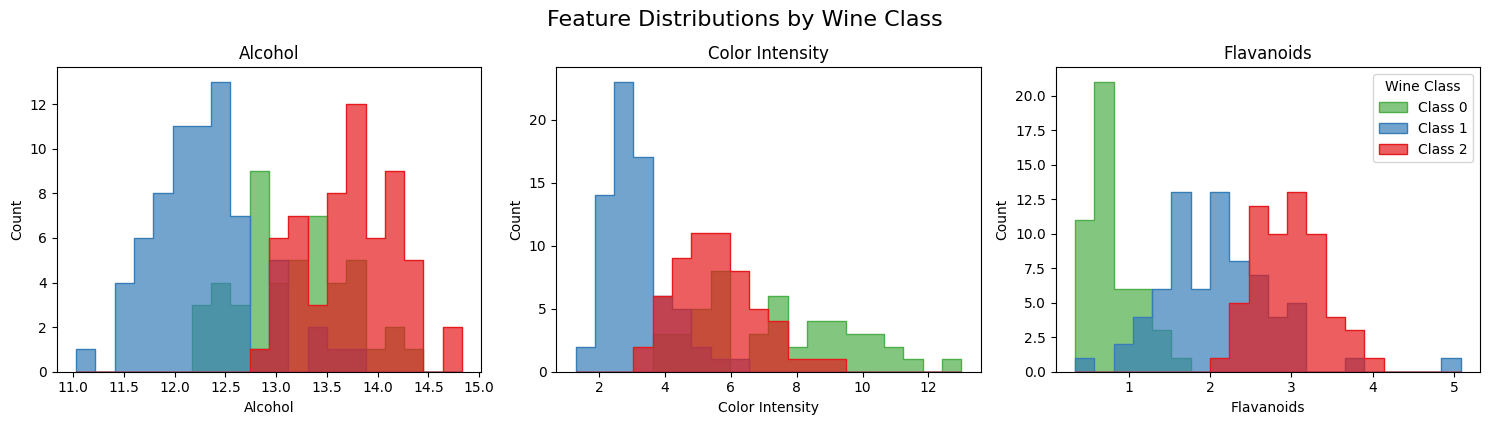

In [ ]:
# Create DataFrame for easier plotting
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

# Visualize distributions of key features, colored by wine class
plt.figure(figsize=(15, 4))
for i, feat in enumerate(['alcohol', 'color_intensity', 'flavanoids']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feat, hue='wine_class', palette='Set1', bins=20, alpha=0.7, 
                 legend=(i==2), element="step")
    plt.title(feat.replace('_', ' ').title())
    plt.xlabel(feat.replace('_', ' ').title())
    plt.ylabel('Count')
    if i == 2:
        plt.legend(labels=[f'Class {i}' for i in range(3)], title='Wine Class')
plt.tight_layout()
plt.suptitle("Feature Distributions by Wine Class", fontsize=16, y=1.05)
plt.show()

<br><br>
# **K-Means/K-Medoids Clustering**

**K-Means Clustering** is a simple and popular approach for partitioning a dataset into *K* distinct, non-overlapping clusters. It's one of the most widely used unsupervised learning algorithms in data science.

## Key Characteristics
- **Must specify K beforehand** - You need to decide how many clusters to find
- **Centroid-based** - Each cluster is represented by its center point (centroid)
- **Iterative algorithm** - Repeats steps until convergence
- **Goal** - Minimize the within-cluster variation and maximize the between-cluster variation
- **Assumes spherical clusters** - Works best when clusters are roughly round and similar sizes
- **Sensitive to outliers** - Extreme values can significantly affect cluster centers

## Dataset for Demonstration

To understand how K-Means works, we'll create a **simulated 2D dataset** with known cluster structure. We'll generate 300 data points distributed across 4 natural clusters, then demonstrate how to discover this structure using clustering algorithms. Feel free to adjust the parameters to experiment!


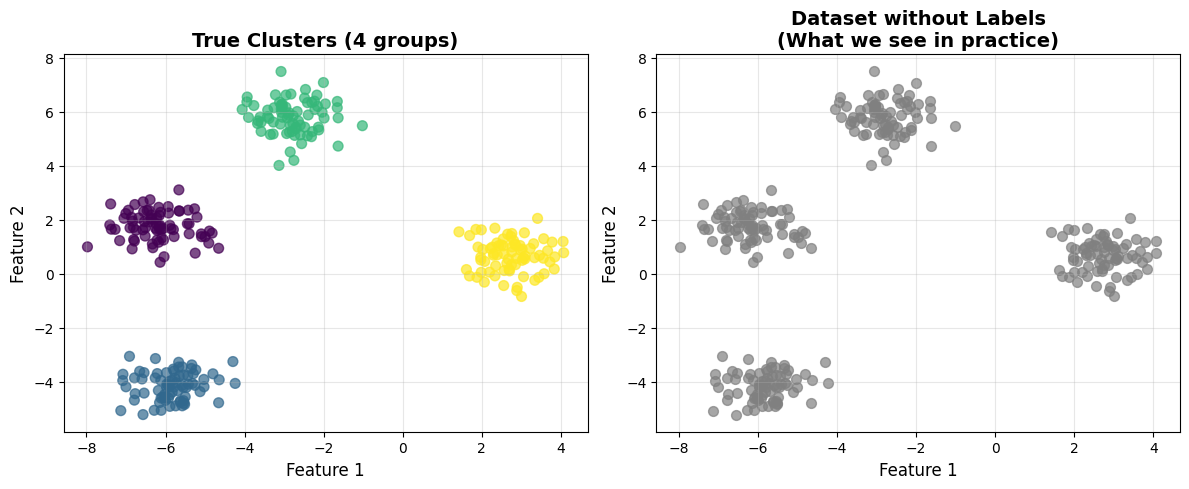

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(42)

# Parameters for the dataset
n_samples = 300
n_features = 2
centers = 4

# Generate a clean 2D dataset with 4 clusters
X_clean, y_true = make_blobs(
    n_samples=n_samples, 
    centers=centers, 
    n_features=n_features,
    cluster_std=0.6,
    center_box=(-8.0, 8.0),
    random_state=43
)

# Create DataFrame for easier handling
df_clean = pd.DataFrame(X_clean, columns=['Feature_1', 'Feature_2'])
df_clean['true_cluster'] = y_true

# Visualize the clean dataset
plt.figure(figsize=(12, 5))

# Plot 1: True clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', alpha=0.7, s=50)
plt.title('True Clusters (4 groups)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot 2: All points (no color coding)
plt.subplot(1, 2, 2)
plt.scatter(X_clean[:, 0], X_clean[:, 1], alpha=0.7, s=50, color='gray')
plt.title('Dataset without Labels\n(What we see in practice)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Finding the Right Number of Clusters: The Elbow Method

Before applying K-Means, we need to determine the optimal number of clusters *K*. The **Elbow Method** helps us find this sweet spot:

- **Run K-Means** for different values of K (e.g., 1 to 10)
- **Calculate WCSS** (Within-Cluster Sum of Squares) for each K, this shows how tightly grouped the data points are within each cluster
- **Plot the results** and look for the "elbow" - where adding more clusters gives diminishing returns
- **Choose K** at the elbow point where the curve starts to flatten

The elbow represents the optimal balance between model complexity and clustering quality.

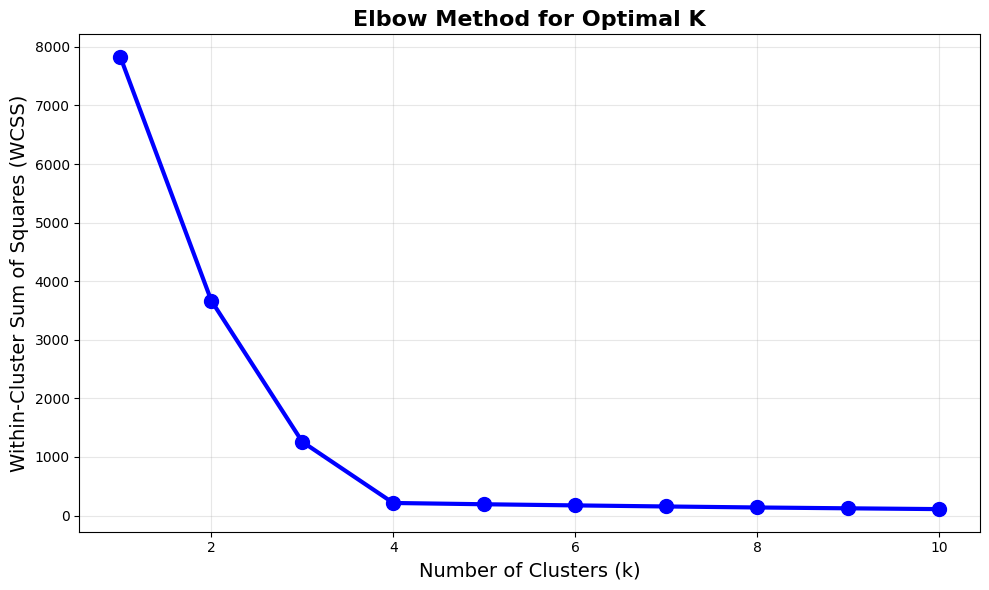

In [111]:
# Elbow Method to find optimal number of clusters
k_range = range(1, 11)
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clean)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linewidth=3, markersize=10, color='blue')
plt.title('Elbow Method for Optimal K', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Looking at the plot, we see clearly a diminishing return at 3/4 clusters. These would be ideal values to choose as numbers of clusters when running K-Means. Now that we found a suitable *K* for our dataset, let's look in detail how K-Means actually works.

## How K-Means Works:

**Step 1: Initialize**
- Choose *K* random starting points as initial cluster centroids
- Common methods: random points, K-means++ (smarter initialization)

**Step 2: Assignment**
- For each data point, calculate distance to all centroids
- Assign each point to the closest centroid's cluster

**Step 3: Update**
- Calculate the mean (centroid) of all points in each cluster
- Move the centroid to this new mean position

**Step 4: Repeat**
- Repeat steps 2-3 until convergence:
  - Centroids stop moving significantly, OR
  - Cluster assignments stop changing, OR
  - Maximum iterations reached

Let's see how well K-Means performs on our dataset and visualize the clustering process step by step!

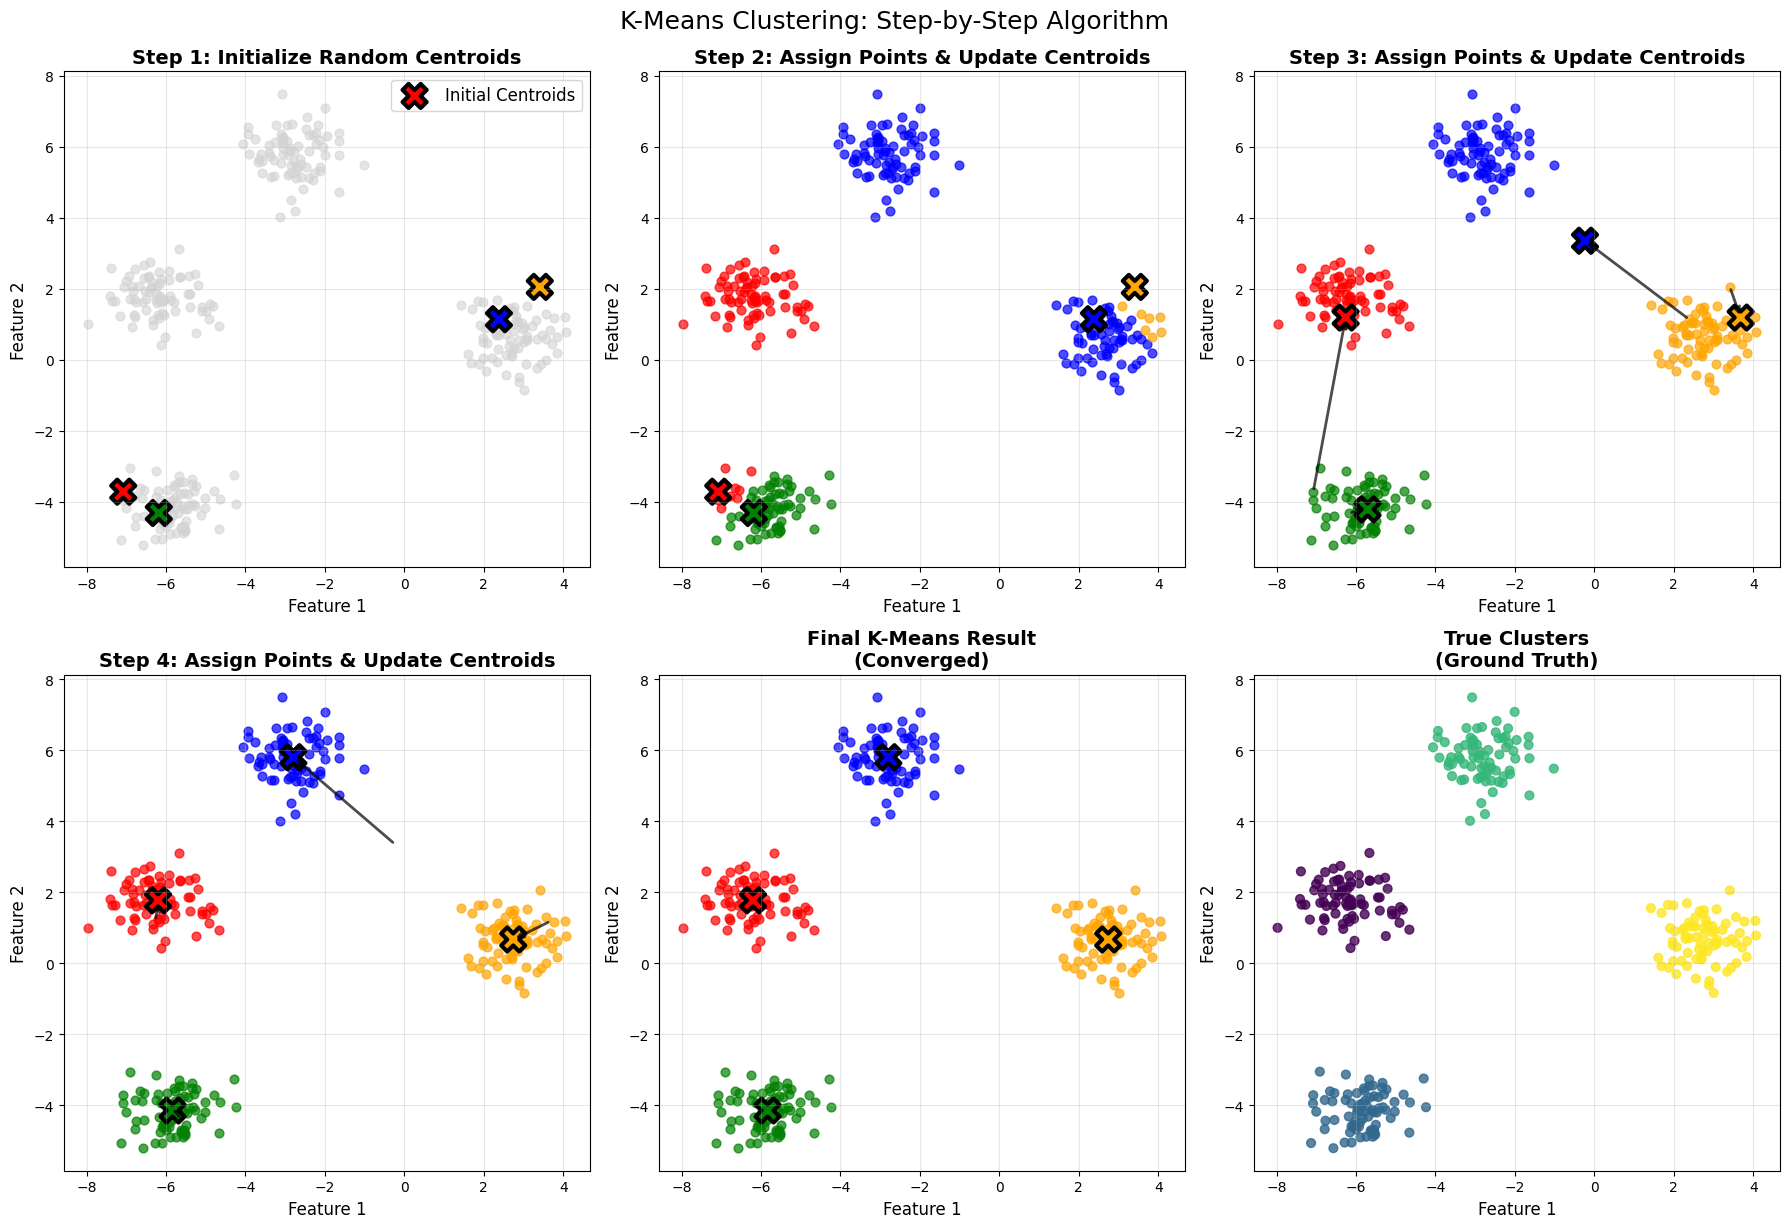

In [112]:
# Manual K-Means implementation for step-by-step visualization
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def assign_clusters(X, centroids):
    clusters = []
    for point in X:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def update_centroids(X, clusters, k):
    centroids = []
    for i in range(k):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
        else:
            centroid = X[np.random.randint(0, len(X))]  # Handle empty clusters
        centroids.append(centroid)
    return np.array(centroids)

# Initialize K=4 random centroids (we know there are 4 true clusters)
np.random.seed(40)
k = 4
initial_centroids = X_clean[np.random.choice(X_clean.shape[0], k, replace=False)]

# Colors for visualization
colors = ['red', 'blue', 'green', 'orange']

# Step-by-step K-Means
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

centroids = initial_centroids.copy()
all_centroids_history = [centroids.copy()]  # Track centroid movement

for iteration in range(6):
    
    if iteration == 0:
        # Initial state
        axes[iteration].scatter(X_clean[:, 0], X_clean[:, 1], c='lightgray', s=40, alpha=0.6)
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=300, marker='X', 
                              edgecolors='black', linewidth=3, label='Initial Centroids')
        axes[iteration].set_title('Step 1: Initialize Random Centroids', fontsize=14, fontweight='bold')
        axes[iteration].legend(fontsize=12)
        
    elif iteration <= 3:
        # Assign points to clusters
        clusters = assign_clusters(X_clean, centroids)
        
        # Plot points colored by cluster assignment
        for i in range(k):
            mask = clusters == i
            if np.any(mask):
                axes[iteration].scatter(X_clean[mask, 0], X_clean[mask, 1], c=colors[i], s=40, alpha=0.7, 
                                      label=f'Cluster {i}')
        
        # Plot current centroids
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=300, marker='X', 
                              edgecolors='black', linewidth=3)
        
        # Show centroid movement with arrows (except first iteration)
        if iteration > 1 and len(all_centroids_history) > 1:
            old_centroids = all_centroids_history[-2]
            for i in range(k):
                axes[iteration].annotate('', xy=centroids[i], xytext=old_centroids[i],
                                       arrowprops=dict(arrowstyle='->', lw=2, color='black', alpha=0.7))
        
        axes[iteration].set_title(f'Step {iteration + 1}: Assign Points & Update Centroids', 
                                fontsize=14, fontweight='bold')
        
        # Update centroids for next iteration
        if iteration < 3:
            centroids = update_centroids(X_clean, clusters, k)
            all_centroids_history.append(centroids.copy())
            
    elif iteration == 4:
        # Final K-means result
        final_clusters = assign_clusters(X_clean, centroids)
        for i in range(k):
            mask = final_clusters == i
            if np.any(mask):
                axes[iteration].scatter(X_clean[mask, 0], X_clean[mask, 1], c=colors[i], s=40, alpha=0.7)
        
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=300, marker='X', 
                              edgecolors='black', linewidth=3)
        axes[iteration].set_title('Final K-Means Result\n(Converged)', fontsize=14, fontweight='bold')
        
    else:
        # Show true clusters for comparison
        scatter = axes[iteration].scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', s=40, alpha=0.8)
        axes[iteration].set_title('True Clusters\n(Ground Truth)', fontsize=14, fontweight='bold')
    
    # Formatting
    axes[iteration].set_xlabel('Feature 1', fontsize=12)
    axes[iteration].set_ylabel('Feature 2', fontsize=12)
    axes[iteration].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('K-Means Clustering: Step-by-Step Algorithm', fontsize=18, y=1.02)
plt.show()

### Key Observations

**Excellent Performance:**
- **Perfect clustering**: Successfully identified all 4 natural clusters
- **Fast convergence**: Stabilized in just 3-4 iterations
- **Accurate results**: Final clusters match ground truth perfectly

**Why K-Means Worked Well:**
- Well-separated, spherical clusters of similar sizes
- No outliers to distort the centroids
- Clean data matching K-means assumptions

Let's use KMeans now with the `Scikit-learn` package!

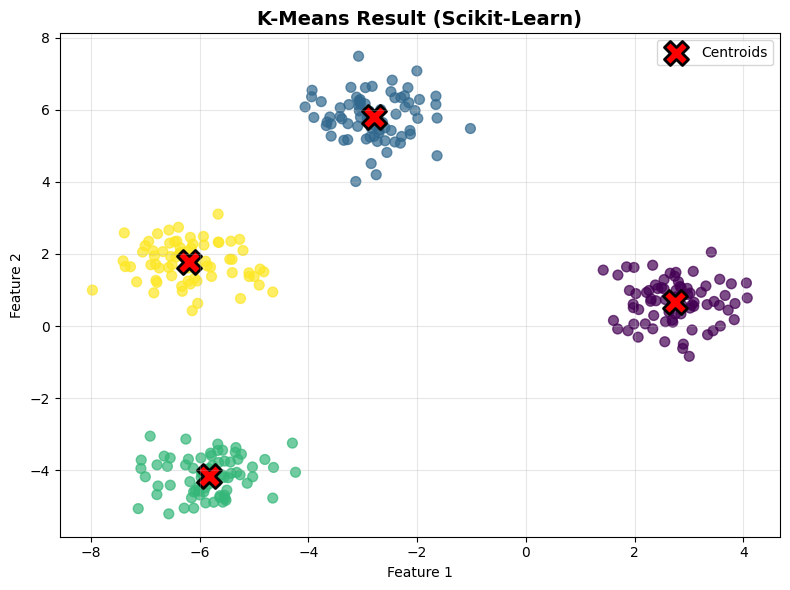

In [113]:
# Apply K-Means with k=4 (from elbow method)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_clean)
kmeans_centroids = kmeans.cluster_centers_

# Visualize results
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2, label='Centroids')
plt.title('K-Means Result (Scikit-Learn)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Measuring Cluster Quality with silhouette score

The **silhouette score** measures how well each point fits in its assigned cluster compared to other clusters. It ranges from -1 to 1:
- **Close to 1**: Point is well-matched to its cluster and far from others
- **Close to 0**: Point is on the border between clusters  
- **Negative**: Point might be in the wrong cluster

Let's visualize the silhouette scores for our K-means result:

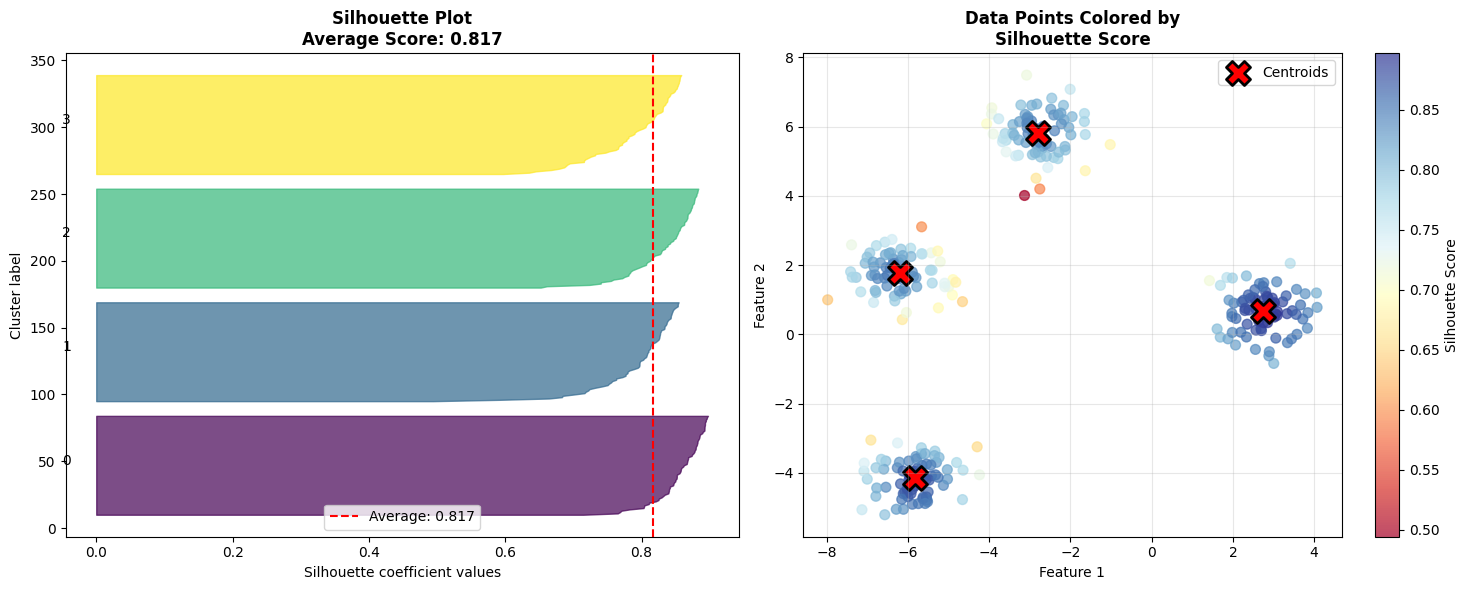

In [115]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Calculate silhouette scores
silhouette_avg = silhouette_score(X_clean, kmeans_labels)
sample_silhouette_values = silhouette_samples(X_clean, kmeans_labels)

# Create silhouette plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Silhouette plot
y_lower = 10
colors = cm.viridis(np.linspace(0, 1, 4))

for i in range(4):
    # Get silhouette scores for cluster i
    cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label clusters
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster label')
ax1.set_title(f'Silhouette Plot\nAverage Score: {silhouette_avg:.3f}', fontweight='bold')

# Add vertical line for average score
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", 
           label=f'Average: {silhouette_avg:.3f}')
ax1.legend()

# Plot 2: Clustered data with silhouette coloring
scatter = ax2.scatter(X_clean[:, 0], X_clean[:, 1], c=sample_silhouette_values, 
                     cmap='RdYlBu', alpha=0.7, s=50)
ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2, label='Centroids')
ax2.set_title('Data Points Colored by\nSilhouette Score', fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add colorbar
plt.colorbar(scatter, ax=ax2, label='Silhouette Score')

plt.tight_layout()
plt.show()

As we can see from the silhouette analysis (score: 0.817), K-means performed exceptionally well on our clean dataset. This makes sense because:

- **Well-separated clusters**: Clear gaps between groups
- **Spherical shapes**: Matches K-means assumptions  
- **No noise**: Clean, ideal conditions

However real datasets often contain outliers, noise, and messy data. Let's stress-test K-means by adding some extreme outliers and see how robust it really is...

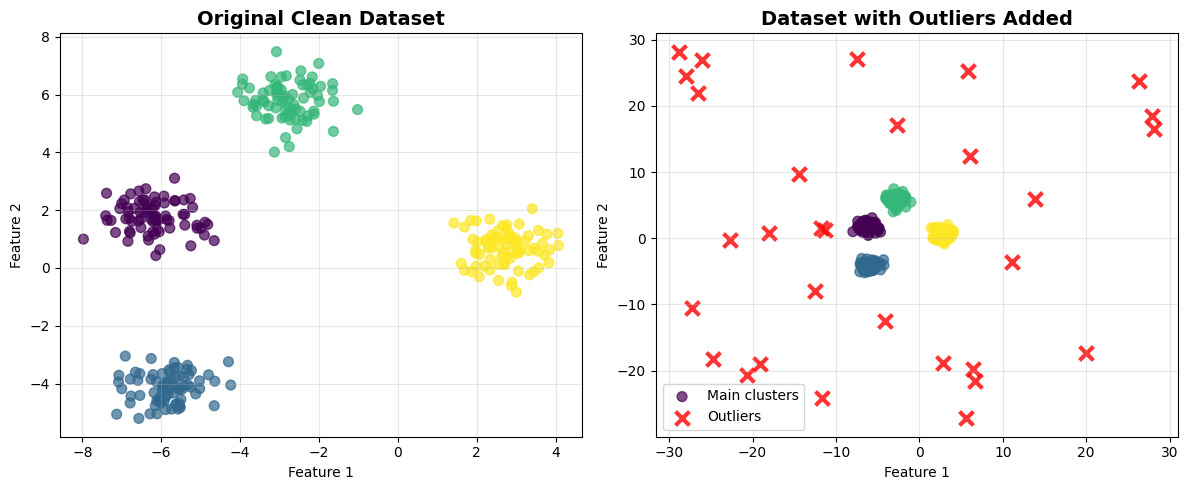

In [121]:
# Add outliers to the clean dataset
np.random.seed(42)  # Different seed for outliers
n_outliers = 30

# Generate outliers at random positions far from main clusters
outlier_range = (-30, 30)  # Wider range than main data
X_outliers = np.random.uniform(outlier_range[0], outlier_range[1], (n_outliers, 2))

# Combine clean data with outliers
X_with_outliers = np.vstack([X_clean, X_outliers])

# Create labels (original clusters + outlier label)
y_with_outliers = np.hstack([y_true, np.full(n_outliers, -1)])  # -1 for outliers

# Visualize the dataset with outliers
plt.figure(figsize=(12, 5))

# Plot 1: Clean dataset
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', alpha=0.7, s=50)
plt.title('Original Clean Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

# Plot 2: Dataset with outliers
plt.subplot(1, 2, 2)
# Plot main clusters
scatter2 = plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_true, cmap='viridis', alpha=0.7, s=50, label='Main clusters')
# Plot outliers
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', marker='x', s=100, alpha=0.8, label='Outliers', linewidths=3)
plt.title('Dataset with Outliers Added', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

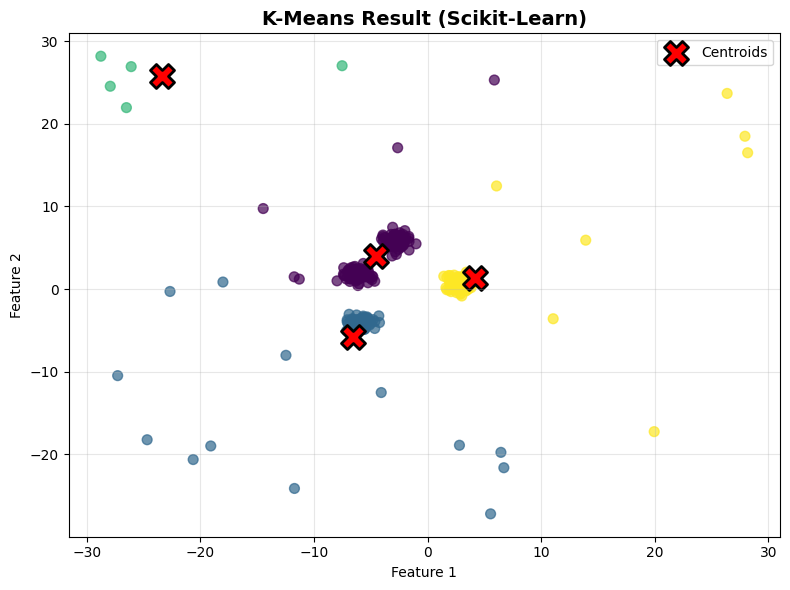

In [122]:
# Apply K-Means with k=4 (from elbow method)
kmeans = KMeans(n_clusters=4, random_state=40, n_init=10)
kmeans_labels = kmeans.fit_predict(X_with_outliers)
kmeans_centroids = kmeans.cluster_centers_

# Visualize results
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2, label='Centroids')
plt.title('K-Means Result (Scikit-Learn)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## From K-Means to K-Medoids

As we can see, K-Means is no longer able to detect the clusters properly due to the outliers, but we have a tool that can help us.

Let's explore **K-Medoids (Paritioning around medoids (PAM))** - a more robust alternative to K-Means.

### Key Differences:

- **Cluster centers**: K-Means uses calculated centroids vs K-Medoids uses actual data points (medoids)
- **Outlier sensitivity**: K-Medoids is more robust to outliers than K-Means
- **Distance metrics**: K-Medoids can use any distance metric, K-Means is limited to Euclidean

### When to Use K-Medoids:

- **Noisy data** with outliers
- **Better interpretability** - medoids are real samples
- **Non-Euclidean data** where averaging doesn't make sense

Let's apply K-Medoids to our dataset and compare the results!

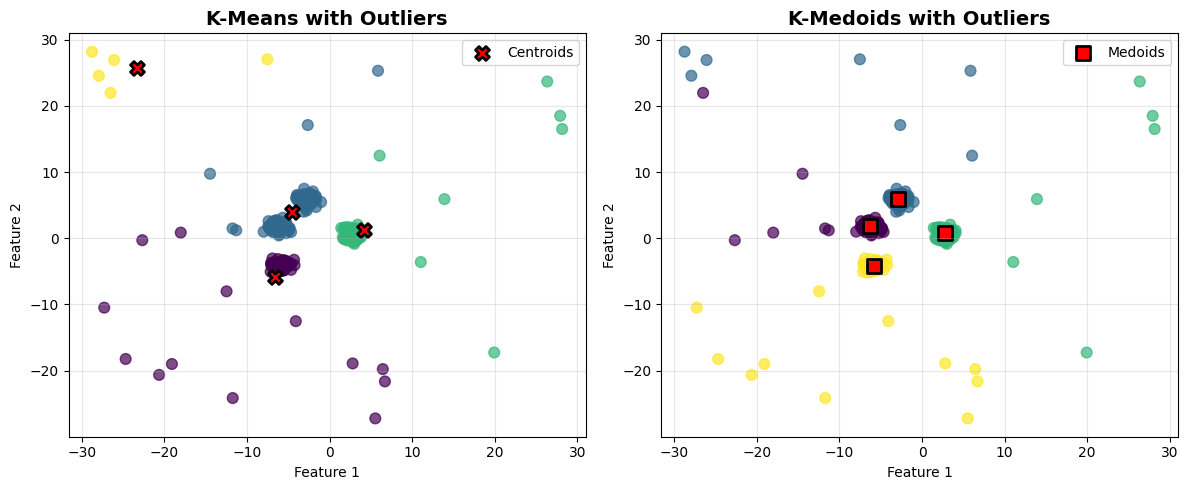

In [ ]:
# K-Medoids clustering on data with outliers
from sklearn.metrics import pairwise_distances

# Apply K-Medoids with k=3 clusters
kmed = kmedoids.KMedoids(n_clusters=4, random_state=42)
euclidean_dist = pairwise_distances(X_with_outliers, metric='euclidean')
kmed.fit(euclidean_dist)

# Get cluster labels and medoid indices
kmedoids_labels = kmed.labels_
medoid_indices = kmed.medoid_indices_
medoids = X_with_outliers[medoid_indices]

# Visualize K-Medoids results
plt.figure(figsize=(12, 5))

# Plot 1: K-Means on data with outliers (for comparison)
plt.subplot(1, 2, 1)
kmeans_outliers = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_outliers_labels = kmeans_outliers.fit_predict(X_with_outliers)
kmeans_outliers_centroids = kmeans_outliers.cluster_centers_

scatter1 = plt.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=kmeans_outliers_labels, 
                      cmap='viridis', alpha=0.7, s=60)
plt.scatter(kmeans_outliers_centroids[:, 0], kmeans_outliers_centroids[:, 1], 
           c='red', marker='X', s=100, edgecolors='black', linewidth=2, label='Centroids')
# Highlight outliers
outlier_mask = X_with_outliers == -1
plt.title('K-Means with Outliers', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: K-Medoids results
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], c=kmedoids_labels, 
                      cmap='viridis', alpha=0.7, s=60)
plt.scatter(medoids[:, 0], medoids[:, 1], 
           c='red', marker='s', s=100, edgecolors='black', linewidth=2, label='Medoids')
plt.title('K-Medoids with Outliers', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Perfect! Now with the extreme outliers we can clearly see that K-Medoids shines and doesn't overfit to the data!**

Notice the key differences:

- **K-Means centroids** (left plot): The red X markers are pulled away from the true cluster centers by the outliers, especially visible in the top cluster where the centroid is displaced toward the outlying points.

- **K-Medoids medoids** (right plot): The red square markers remain firmly within the actual cluster cores, as they must be real data points from the dataset. The outliers cannot "pull" the medoids away from the main clusters.

This demonstrates K-Medoids' **robustness to outliers** - a crucial advantage when dealing with real-world messy data!

## K-Means vs K-Medoids: Comparison

### Similarities:
- Both are partitional clustering methods that divide data into K clusters
- Must specify K beforehand
- Iterative algorithms with assignment and update steps
- Sensitive to initialization and assume similar cluster sizes

### Key Differences:

| Aspect | K-Means | K-Medoids |
|--------|---------|-----------|
| **Cluster Centers** | Calculated centroids | Actual data points |
| **Outlier Sensitivity** | High | Low |
| **Distance Metrics** | Euclidean only | Any metric |
| **Speed** | Faster | Slower |
| **Interpretability** | Centroids may not exist | Medoids are real samples |

### When to Use:

**K-Means:**
- Large datasets (computational efficiency)
- Clean data without outliers
- All continuous features

**K-Medoids:**
- Noisy data with outliers
- Need interpretable cluster centers
- Mixed data types or non-Euclidean distances

---
<br><br>
# **Hierarchical Clustering**

K-Means and K-Medoids require specifying the number of clusters K beforehand. **Hierarchical Clustering** offers an alternative approach that discovers the cluster structure without needing to choose K in advance.

### Key Advantages:
- **No need to specify K** - Algorithm reveals natural cluster structure
- **Dendrogram visualization** - Tree-based representation shows relationships between all data points
- **Multiple granularities** - extract different numbers of clusters from same result
- **Deterministic** - No random initialization, same result every time

### Types of Hierarchical Clustering:

**Agglomerative (Bottom-Up):**
- Start with each point as its own cluster
- Iteratively merge the two closest clusters
- Continue until all points are in one cluster
- Most common approach

**Divisive (Top-Down):**
- Start with all points in one cluster
- Iteratively split clusters into smaller ones
- Less common due to computational complexity

### How Agglomerative Clustering Works:

**Step 1: Initialize**
- Each data point starts as its own cluster (N clusters for N points)

**Step 2: Find Closest Clusters**
- Calculate distances between all cluster pairs
- Identify the two closest clusters

**Step 3: Merge**
- Combine the closest clusters into one
- Update distance matrix

**Step 4: Repeat**
- Continue merging until only one cluster remains
- Record the merge sequence in a dendrogram

There are different distance metrics that are used to compute hierarchical clusterings, in this context they are called *linkage*. We will look at 4 common ones next.

Let's see how hierarchical clustering reveals the structure in our wine dataset!

### Ward's Method

**Ward's linkage** is the most popular linkage criterion for hierarchical clustering because it creates compact, spherical clusters similar to K-Means.

#### How Ward's Method Works:
- **Objective**: Minimize the increase in within-cluster sum of squares (variance) when merging clusters
- **Strategy**: At each step, merge the two clusters that result in the smallest increase in total variance
- **Result**: Tends to create clusters of similar sizes with low internal variance
- **Balanced clusters** - Avoids creating very large or very small clusters

Now let's apply Ward's method to our wine dataset and learn how to read dendrograms!

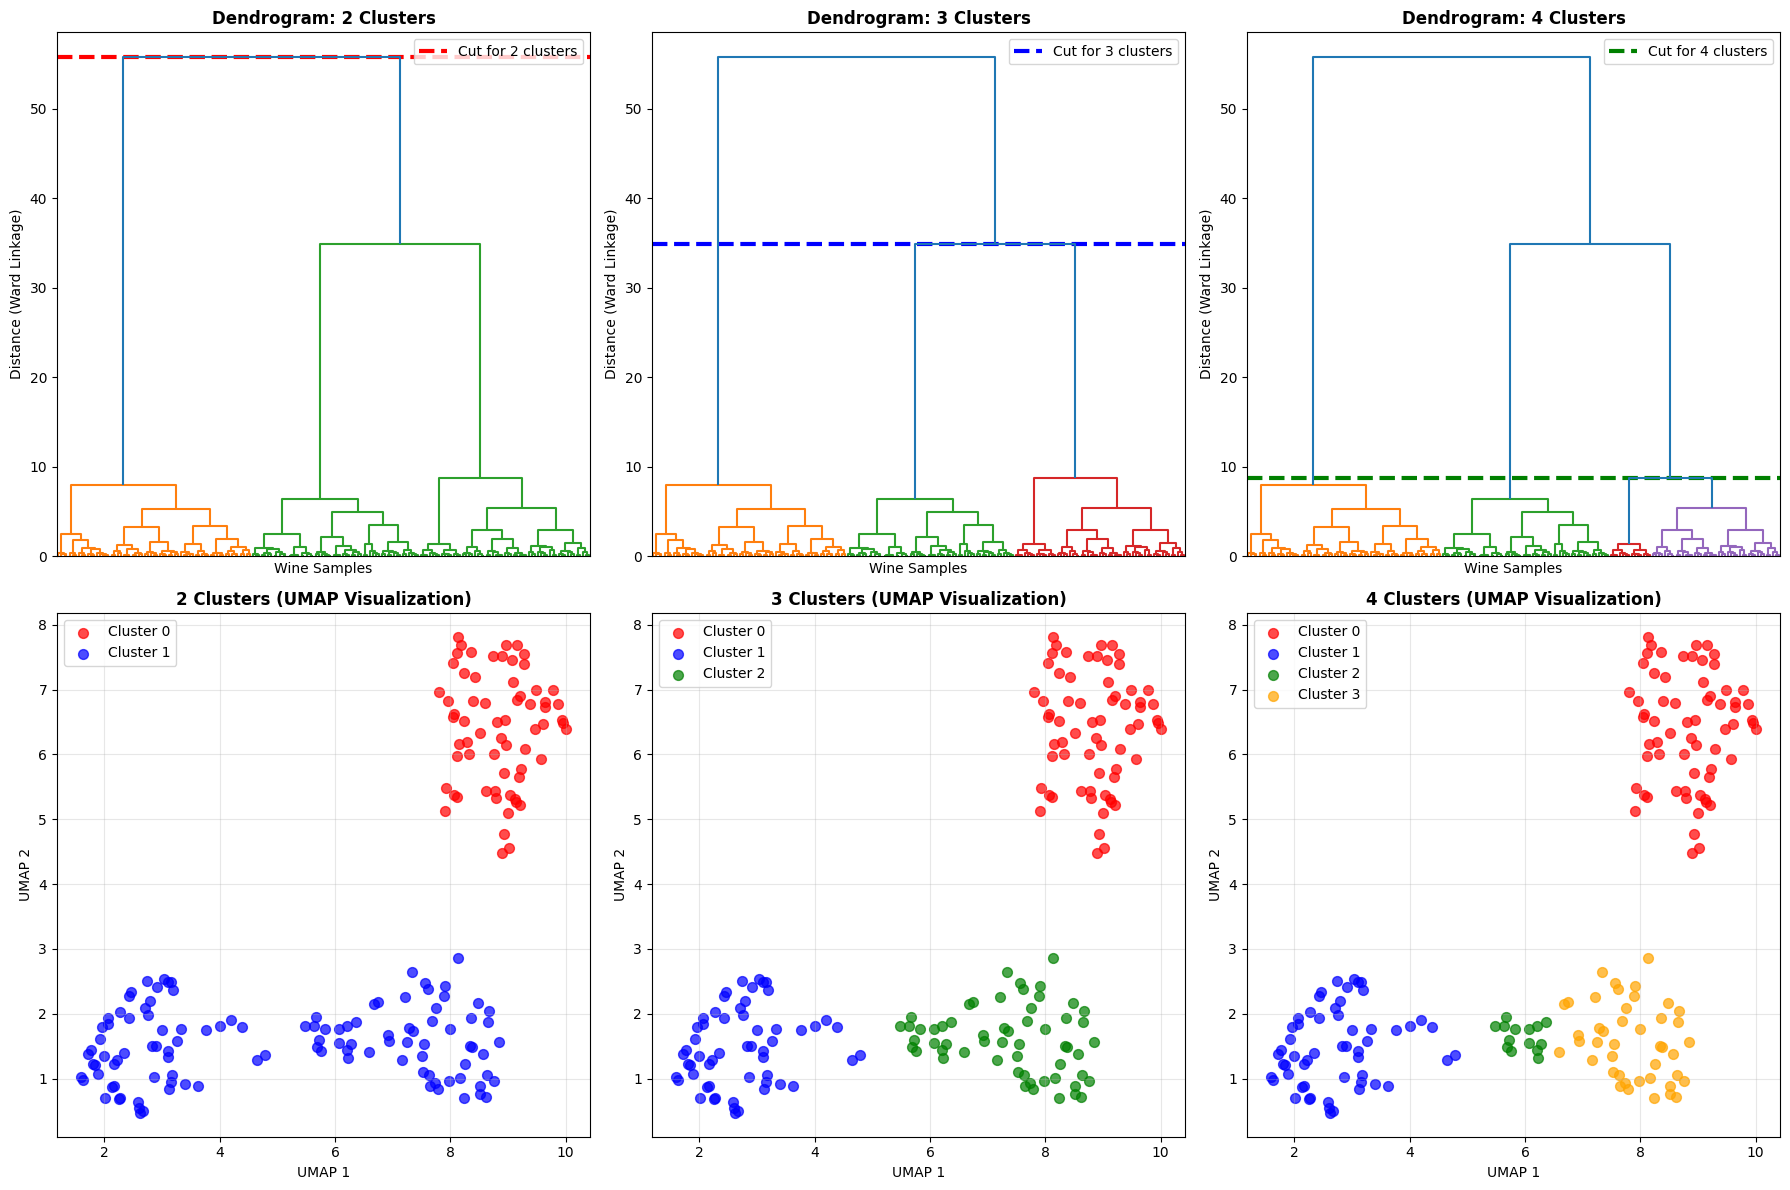

In [ ]:
# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_umap, method='ward')

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Three dendrograms with different cluster cuts
n_clusters_list = [2, 3, 4]
colors_cuts = ['red', 'blue', 'green']
cluster_colors = ['red', 'blue', 'green', 'orange']

for i, n_clusters in enumerate(n_clusters_list):
    ax = axes[0, i]
    
    # Find the distance threshold for n_clusters
    if n_clusters <= len(linkage_matrix):
        threshold = linkage_matrix[-(n_clusters-1), 2]
        ax.axhline(y=threshold, color=colors_cuts[i], linestyle='--', linewidth=3,
                  label=f'Cut for {n_clusters} clusters')
    
    # Create dendrogram
    dend = dendrogram(linkage_matrix, 
                     p=10,
                     leaf_rotation=90,
                     leaf_font_size=8,
                     show_leaf_counts=False,
                     color_threshold=threshold,
                     link_color_func=lambda k: cluster_colors[k],
                     ax=ax)
    
    ax.set_title(f'Dendrogram: {n_clusters} Clusters', fontsize=12, fontweight='bold')
    ax.set_xlabel('Wine Samples', fontsize=10)
    ax.set_ylabel('Distance (Ward Linkage)', fontsize=10)
    ax.legend(loc='upper right')
    
    # Remove x-axis tick labels
    ax.set_xticks([])

# Bottom row: Cluster visualizations for 2, 3, 4 clusters
for i, n_clusters in enumerate([2, 3, 4]):
    ax = axes[1, i]
    
    # Get cluster labels for n_clusters
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1
    
    # Plot points colored by cluster
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                  c=cluster_colors[cluster_id], s=50, alpha=0.7,
                  label=f'Cluster {cluster_id}')
        
    if n_clusters == 3:
        # Store results for comparison
        ward_linkage_labels = cluster_labels
        ward_linkage_matrix = linkage_matrix
    
    ax.set_title(f'{n_clusters} Clusters (UMAP Visualization)', fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## How to Read Dendrograms

### Basic Structure:
- **Y-axis (Height)**: Distance at which clusters merge - higher means more dissimilar
- **X-axis**: Individual wine samples (numbers removed for clarity)
- **Branches**: Show the hierarchical relationship between samples and clusters
- **Colors**: Different colors represent different clusters at the cut level

### Key Elements:
- **Leaf nodes** (bottom): Individual wine samples
- **Internal nodes**: Points where clusters merge
- **Branch height**: Indicates similarity - shorter branches = more similar samples
- **Merge distance**: The height where two branches join

### Using the Cut Line:
- **Horizontal dashed line**: Shows where to "cut" the tree for desired number of clusters
- **Count clusters**: Number of vertical lines the cut line crosses
- **Cluster membership**: Samples connected below the cut belong to same cluster
- **Color coding**: Each cluster gets a different color below the cut line

### Choosing Optimal Number of Clusters:
- **Look for large jumps**: Big increases in merge distance suggest natural cluster boundaries
- **Avoid high cuts**: Don't cut where merge distances are very large
- **Compare solutions**: Use visualization plots to see which clustering makes most sense

For our Wine dataset, choosing 3 Clusters seem to provide a good fit, as there is a clear dissimalirity between the three groups.

## Single Linkage Method

**Single linkage** is the simplest linkage criterion for hierarchical clustering, based on the closest points between clusters.

### How Single Linkage Works:
- **Objective**: Merge clusters with the smallest minimum distance between any two points
- **Strategy**: At each step, find the two clusters whose closest points are nearest to each other
- **Result**: Create elongated, chain-like clusters that follow data patterns
- **Sensitive to outliers** - Single points - bridge distant clusters

Let's see how Single Linkage performs on our wine dataset!

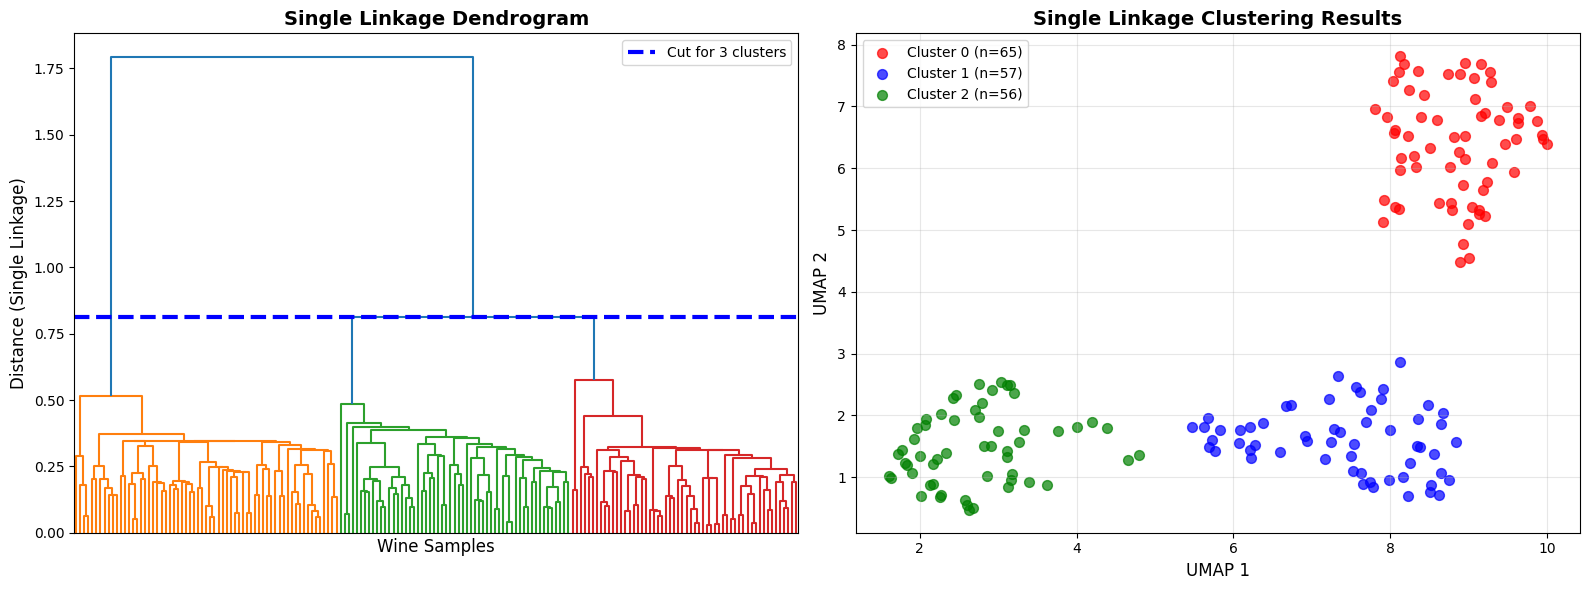

In [ ]:
# Create linkage matrix using Single Linkage method
linkage_matrix_single = linkage(X_umap, method='single')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Single Linkage Dendrogram
cluster_colors = ['red', 'blue', 'green']
ax1 = axes[0]
threshold_single = linkage_matrix_single[-(3-1), 2]  # For 3 clusters

dend_single = dendrogram(linkage_matrix_single, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_single,
                        link_color_func=lambda k: cluster_colors[k],
                        ax=ax1)

ax1.axhline(y=threshold_single, color='blue', linestyle='--', linewidth=3,
           label='Cut for 3 clusters')
ax1.set_title('Single Linkage Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wine Samples', fontsize=12)
ax1.set_ylabel('Distance (Single Linkage)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Single Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_single = fcluster(linkage_matrix_single, 3, criterion='maxclust') - 1

for cluster_id in range(3):
    mask = cluster_labels_single == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Single Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison
single_linkage_labels = cluster_labels_single
single_linkage_matrix = linkage_matrix_single

### Key Observations - Single Linkage:

- **Balanced clusters**: Cluster sizes (65, 57, 56) show some variation but are more balanced than typical
- **Chain formation tendency**: Single linkage is prone to creating elongated clusters by connecting nearest points
- **Sensitive to outliers**: Can create clusters by "chaining" through intermediate points rather than true similarity
- **Mixed separation quality**: While clusters appear distinct in UMAP space, single linkage may not capture true wine class boundaries as effectively as other methods

## Complete Linkage Method

**Complete linkage** (also called "farthest neighbor") is the opposite of single linkage, based on the most distant points between clusters.

### How Complete Linkage Works:
- **Objective**: Merge clusters with the smallest maximum distance between any two points
- **Strategy**: At each step, find the two clusters whose farthest points are closest to each other
- **Result**: Creates compact, tight clusters with similar diameters
- **Conservative merging** - Only merges clusters when even their most distant points are close

### Why Use Complete Linkage?
- **Compact clusters** - Produces spherical, well-separated clusters
- **Outlier resistant** - Less sensitive to outliers than single linkage
- **Balanced sizes** - Tends to create more evenly sized clusters than single linkage

Let's see how Complete Linkage performs on our wine dataset!

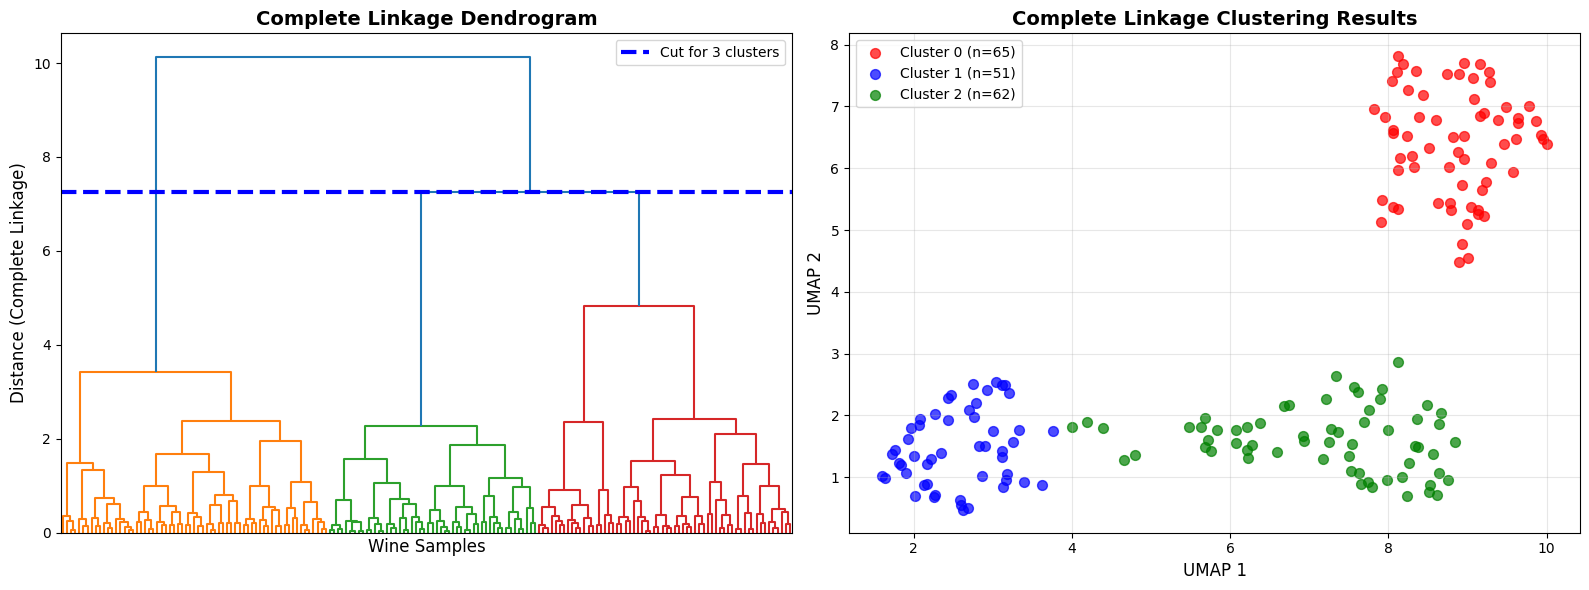

In [ ]:
# Create linkage matrix using Complete Linkage method
linkage_matrix_complete = linkage(X_umap, method='complete')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Complete Linkage Dendrogram
ax1 = axes[0]
threshold_complete = linkage_matrix_complete[-(3-1), 2]  # For 3 clusters

dend_complete = dendrogram(linkage_matrix_complete, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_complete,
                        link_color_func=lambda k: cluster_colors[k],
                        ax=ax1)

ax1.axhline(y=threshold_complete, color='blue', linestyle='--', linewidth=3,
           label='Cut for 3 clusters')
ax1.set_title('Complete Linkage Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wine Samples', fontsize=12)
ax1.set_ylabel('Distance (Complete Linkage)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Complete Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_complete = fcluster(linkage_matrix_complete, 3, criterion='maxclust') - 1

for cluster_id in range(3):
    mask = cluster_labels_complete == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Complete Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison
complete_linkage_labels = cluster_labels_complete
complete_linkage_matrix = linkage_matrix_complete

### Key Observations - Complete Linkage:

- **Good Balance**: Cluster sizes (69, 51, 58) are reasonably even
- **Compact clusters**: Creates tight, well-separated groups instead of chains
- **Good wine class separation**: Successfully identifies 3 distinct wine varieties
- **Conservative merging**: Only merges when farthest points are close, preventing premature connections

## Average Linkage Method

**Average linkage** (also called "UPGMA") uses the average distance between all pairs of points in different clusters as the merging criterion.

### How Average Linkage Works:
- **Objective**: Merge clusters with the smallest average distance between all point pairs
- **Strategy**: Calculate mean distance between every point in cluster A and every point in cluster B
- **Result**: Creates moderately compact clusters, balancing single and complete linkage extremes
- **Compromise approach** - Less sensitive to outliers than single, less conservative than complete

### Why Use Average Linkage?
- **Balanced approach** - Middle ground between single and complete linkage
- **Stable results** - Less affected by individual outlier points
- **Good general purpose** - Works well for many different cluster shapes and sizes

Let's see how Average Linkage performs on our wine dataset!

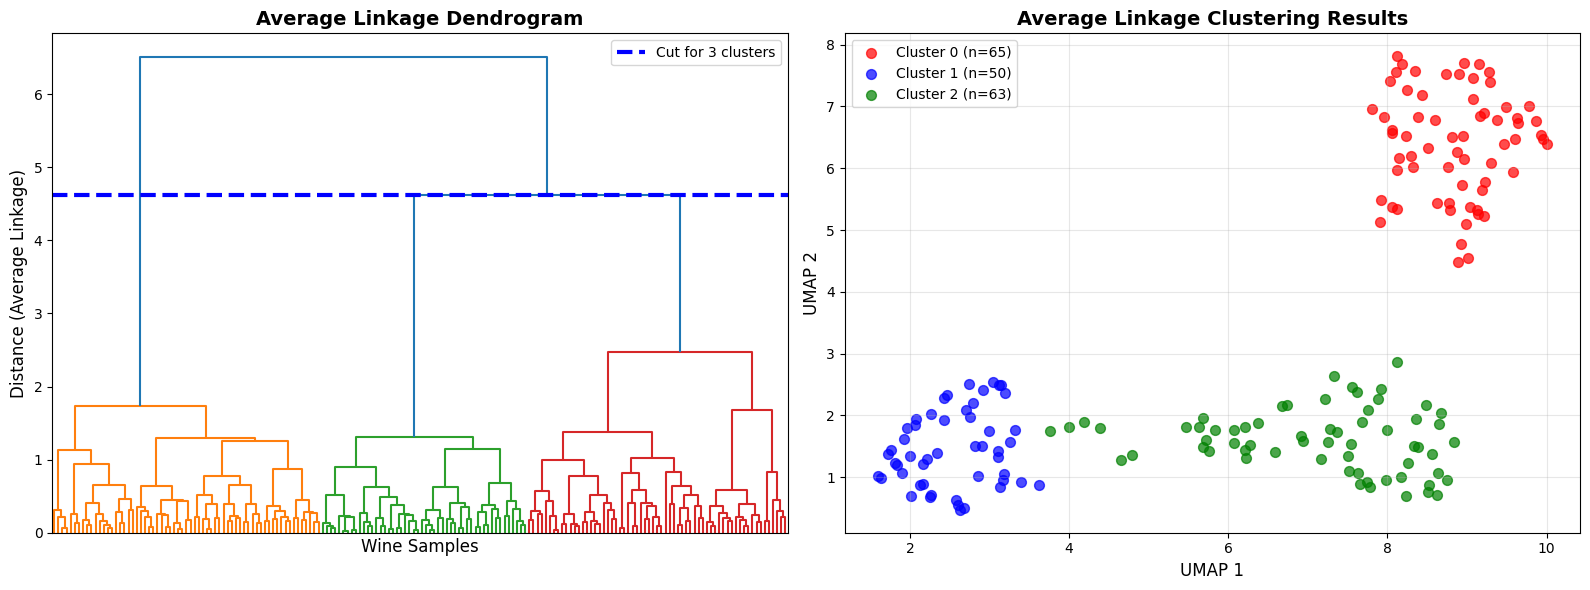

In [ ]:
# Create linkage matrix using Average Linkage method
linkage_matrix_average = linkage(X_umap, method='average')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Average Linkage Dendrogram
ax1 = axes[0]
threshold_average = linkage_matrix_average[-(3-1), 2]  # For 3 clusters

dend_average = dendrogram(linkage_matrix_average, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_average,
                        link_color_func=lambda k: cluster_colors[k],
                        ax=ax1)

ax1.axhline(y=threshold_average, color='blue', linestyle='--', linewidth=3,
           label='Cut for 3 clusters')
ax1.set_title('Average Linkage Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wine Samples', fontsize=12)
ax1.set_ylabel('Distance (Average Linkage)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Average Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_average = fcluster(linkage_matrix_average, 3, criterion='maxclust') - 1

for cluster_id in range(3):
    mask = cluster_labels_average == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Average Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison
average_linkage_labels = cluster_labels_average
average_linkage_matrix = linkage_matrix_average

### Key Observations - Average Linkage:

- **Well-balanced clusters**: Cluster sizes (65, 50, 63) are very evenly distributed across wine samples
- **Moderate clustering approach**: Balances between single linkage's chaining tendency and complete linkage's compactness
- **Clear separation**: Creates distinct, well-separated clusters as shown in the UMAP visualization
- **Robust to outliers**: Less sensitive to noise than single linkage while avoiding over-conservative merging

## Hierarchical Clustering Overview

Hierarchical clustering builds a tree of clusters by iteratively merging the closest pairs. Unlike K-means, it doesn't require specifying the number of clusters beforehand and provides a complete clustering hierarchy.

### Linkage Methods Comparison

| Method | Distance Calculation | Characteristics | Best For |
|--------|---------------------|-----------------|----------|
| **Single** | Minimum distance between any two points | Creates chains, sensitive to outliers | Non-spherical, density-based clusters |
| **Complete** | Maximum distance between any two points | Compact, tight clusters | Well-separated, spherical clusters |
| **Average** | Average distance between all point pairs | Moderate approach, balanced | General purpose, moderate noise |
| **Ward's** | Minimizes within-cluster variance | Balanced sizes, spherical clusters | Most datasets, similar to K-means |

### When to Use Hierarchical Clustering:
- **Exploratory analysis** - when you don't know the number of clusters
- **Small to medium datasets** (computational complexity is O(n³))
- **Need cluster hierarchy** - understanding relationships between clusters
- **Deterministic results** - same input always gives same output

---
<br><br>
# **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

K-Means, K-Medoids, and Hierarchical Clustering all assume clusters have similar sizes and densities. **DBSCAN** takes a fundamentally different approach by finding clusters based on local density.

### Key Advantages:
- **No need to specify number of clusters** - Algorithm discovers clusters automatically
- **Handles arbitrary cluster shapes** - Not limited to spherical clusters like K-means
- **Robust to outliers** - Identifies and labels noise points explicitly
- **Density-based** - Finds clusters of varying sizes and densities
- **Deterministic** - Same parameters always give same results

### Core Concepts:

**Dense Regions vs Sparse Regions:**
- **Core idea**: Clusters are dense regions separated by sparse regions
- **Noise points**: Isolated points in low-density areas
- **Arbitrary shapes**: Can find elongated, curved, or irregular clusters

### How DBSCAN Works:

**Step 1: Define Density**
- **ε (epsilon)**: Maximum distance to consider points as neighbors
- **MinPts**: Minimum number of points required to form a dense region

**Step 2: Classify Points**
- **Core points**: Have at least MinPts neighbors within ε distance
- **Border points**: Not core points but within ε of a core point
- **Noise points**: Neither core nor border points

**Step 3: Form Clusters**
- Start with any unvisited core point
- Add all density-reachable points to the same cluster
- Repeat until all core points are processed

**Step 4: Handle Remaining Points**
- Border points join the cluster of nearest core point
- Noise points remain unassigned (labeled as -1)

### Parameter Selection Challenge:
The biggest challenge with DBSCAN is choosing appropriate **ε** and **MinPts** parameters. Too small values create many small clusters, too large values merge everything into one cluster.

Let's explore how different parameter settings affect our wine dataset clustering!

💡 Look for the 'elbow' or 'knee' in the curve
💡 Suggested ε values: [0.26 0.28 0.29 0.3 ]


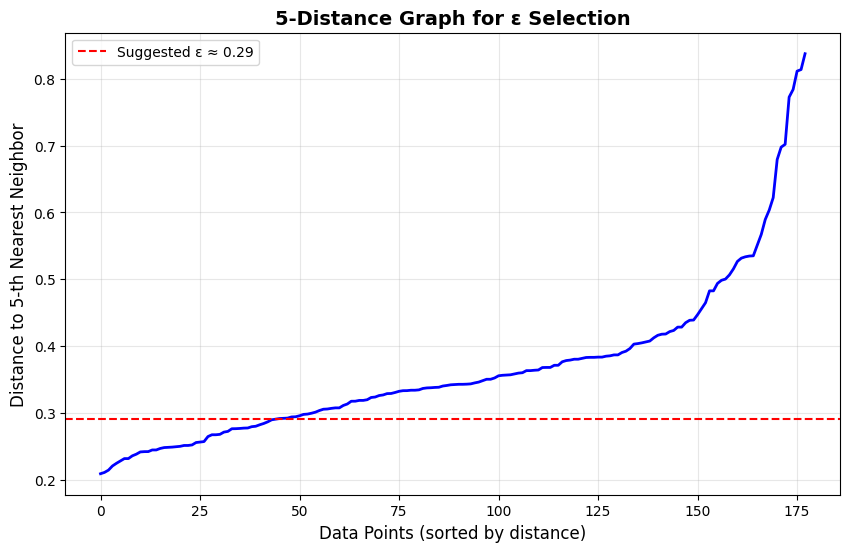

In [ ]:
# K-Distance Graph for Epsilon Selection
def plot_k_distance_graph(X, k=4):
    """Plot k-distance graph to help choose epsilon"""
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Sort distances to k-th nearest neighbor
    k_distances = np.sort(distances[:,k-1])#np.sort(distances[:, k-1], axis=0)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
    plt.title(f'{k}-Distance Graph for ε Selection', fontsize=14, fontweight='bold')
    plt.xlabel('Data Points (sorted by distance)', fontsize=12)
    plt.ylabel(f'Distance to {k}-th Nearest Neighbor', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Highlight potential epsilon values
    knee_point = len(k_distances) // 4  # Rough estimate
    plt.axhline(y=k_distances[knee_point], color='red', linestyle='--', 
                label=f'Suggested ε ≈ {k_distances[knee_point]:.2f}')
    plt.legend()
    
    print(f"Suggested ε values: {k_distances[knee_point-20:knee_point+20:10].round(2)}")
    plt.show()
    
    return k_distances

# Plot k-distance graph
k_distances = plot_k_distance_graph(X_umap, k=5)

### Understanding the K-Distance Graph

The **k-distance graph** is a crucial tool for selecting the optimal ε parameter in DBSCAN. Here's how to interpret it:

#### What the Graph Shows:
- **X-axis**: All data points sorted by their distance to the k-th nearest neighbor (k=5 here)
- **Y-axis**: The actual distance to that k-th nearest neighbor
- **Curve shape**: Shows the distribution of local densities in your dataset

#### How to Use It:
- **Look for the "elbow" or "knee"**: The point where the curve changes from gradual to steep
- **Elbow location**: Around ε ≈ 0.29 in this case
- **Interpretation**: Points to the left are in dense regions, points to the right are in sparse regions

#### Why This Works:
- **Dense regions** (left side): Points have close neighbors → small k-distances
- **Sparse regions** (right side): Points are isolated → large k-distances  
- **The elbow**: Separates dense cores from sparse noise/boundaries

#### Parameter Selection:
- **Choose ε at the elbow**: ε ≈ 0.29 suggested here
- **Too small ε**: Only very dense cores become clusters (many noise points)
- **Too large ε**: Sparse regions get merged (few large clusters)


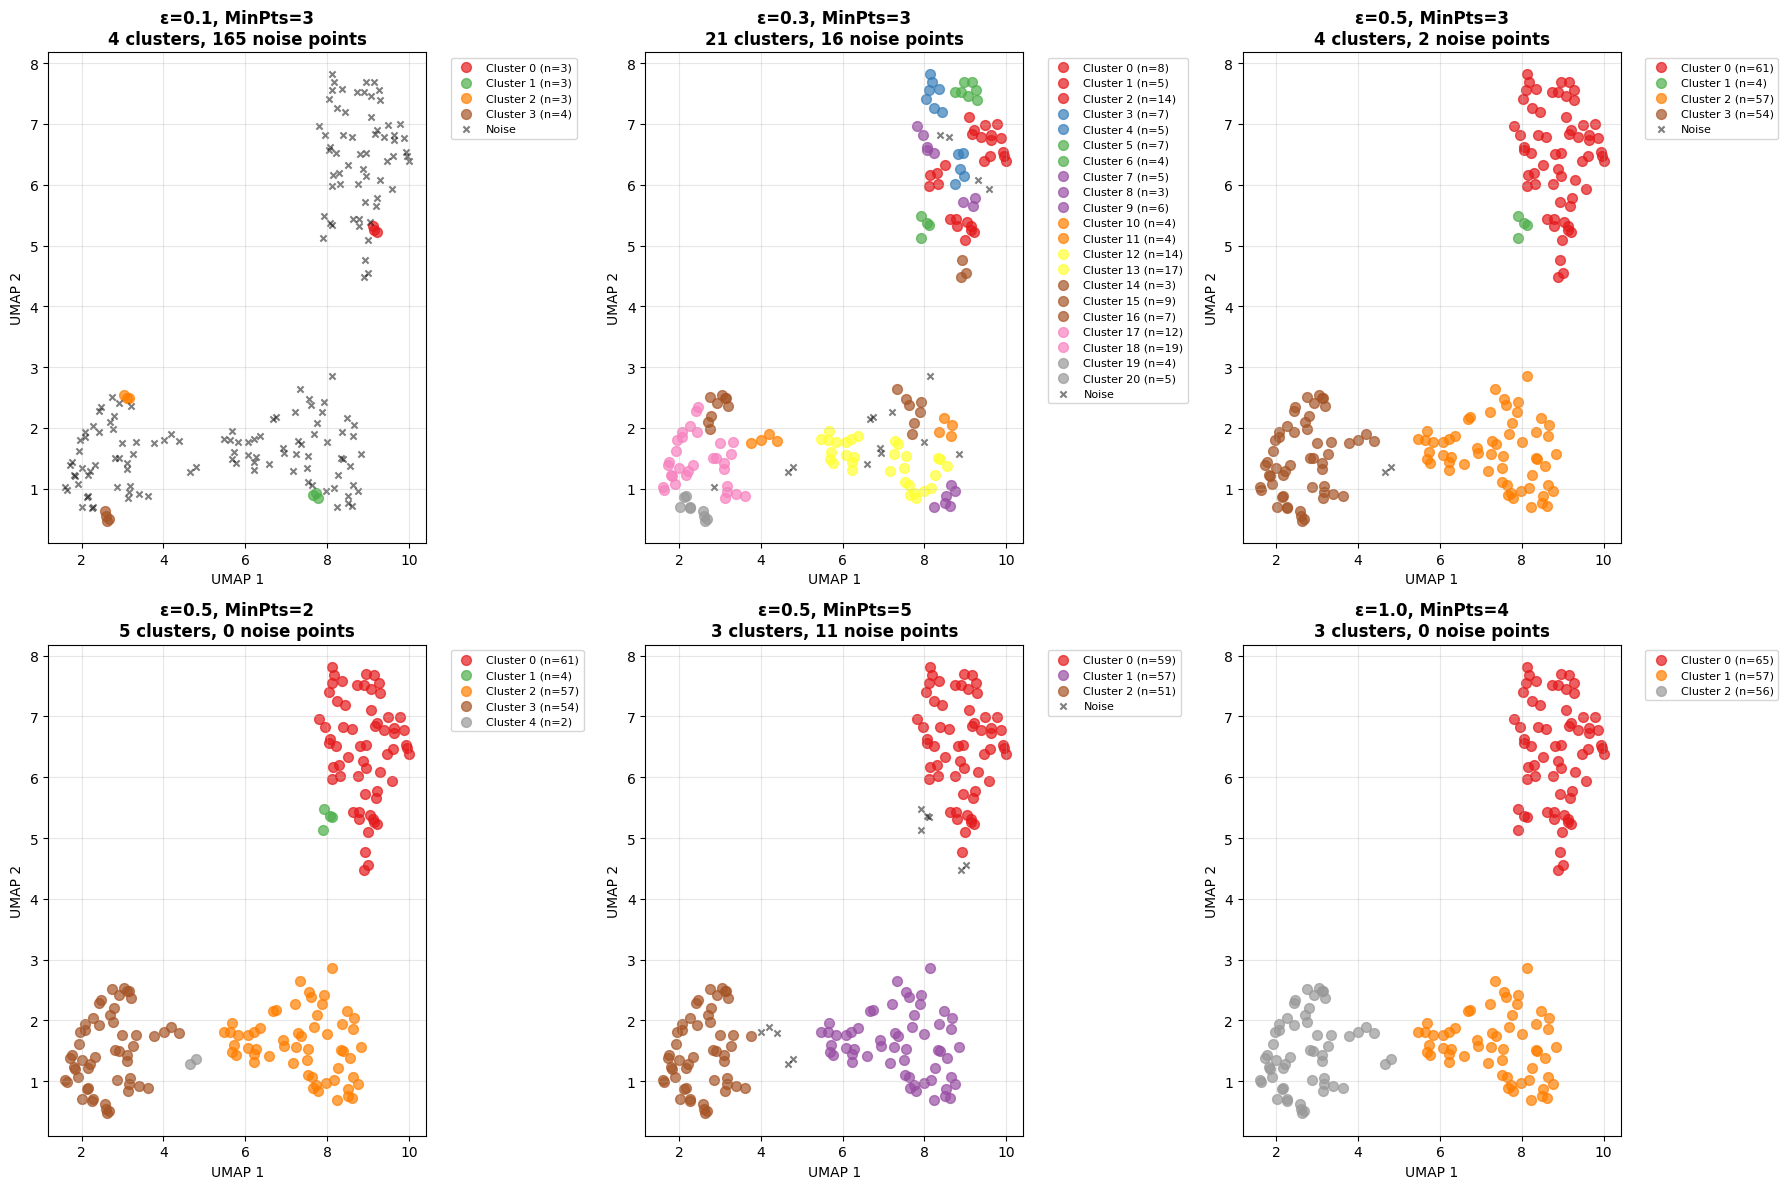

In [ ]:
# Parameter Sensitivity Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Different epsilon and MinPts combinations
param_combinations = [
    (0.1, 3, "ε=0.1, MinPts=3"),
    (0.3, 3, "ε=0.3, MinPts=3"), 
    (0.5, 3, "ε=0.5, MinPts=3"),
    (0.5, 2, "ε=0.5, MinPts=2"),
    (0.5, 5, "ε=0.5, MinPts=5"),
    (0.8, 4, "ε=1.0, MinPts=4")
]

for i, (eps, min_pts, title) in enumerate(param_combinations):
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    cluster_labels = dbscan.fit_predict(X_umap)
    
    # Count clusters and noise
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    # Plot results
    ax = axes[i]
    
    # Plot clusters
    unique_labels = set(cluster_labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points in black
            mask = cluster_labels == label
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c='black', s=20, alpha=0.5, marker='x', label='Noise')
        else:
            mask = cluster_labels == label
            cluster_size = np.sum(mask)
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c=[color], s=50, alpha=0.7, 
                      label=f'Cluster {label} (n={cluster_size})')
    
    ax.set_title(f'{title}\n{n_clusters} clusters, {n_noise} noise points', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### DBSCAN Parameter Effects

**ε (epsilon)**: Maximum distance between points to be considered neighbors
**MinPts**: Minimum number of neighbors required for a point to be a "core point"

### Key Observations from Parameter Grid:

**ε Effect (horizontal comparison):**
- **Small ε (0.1)**: Very strict neighborhoods → few clusters, lots of noise
- **Medium ε (0.3)**: Too many tiny clusters (over-segmentation)
- **Larger ε (0.5-1.0)**: Balanced clustering with reasonable cluster sizes

**MinPts Effect (vertical comparison):**
- **Low MinPts (2)**: Less strict density requirement → fewer noise points
- **High MinPts (5)**: Stricter density requirement → more noise points

**Best Results:**
- **ε=0.5, MinPts=5**: Clean separation into 3 clusters (matches wine varieties!)
- **ε=1.0, MinPts=4**: Also good with 3 well-separated clusters
- **Sweet spot**: ε around 0.5-1.0 captures the natural wine variety structure

The k-distance graph suggestion (ε≈0.29) was close but slightly conservative - real-world parameter tuning often requires experimentation around the suggested value.

---
<br><br>
# **Clustering Methods Overview**

### K-Means & K-Medoids Clustering
- **Advantages:**
  - Fast and scalable for large datasets (K-Means faster)
  - Simple to implement and understand
  - Works well with spherical, similar-sized clusters
  - **K-Medoids**: More robust to outliers, uses actual data points as centers

- **Disadvantages:**
  - Must specify k beforehand
  - Assumes spherical clusters
  - **K-Means**: Sensitive to outliers and initialization
  - **K-Medoids**: Slower than K-Means, still sensitive to initialization

### Hierarchical Clustering
- **Advantages:**
  - No need to specify number of clusters
  - Provides complete hierarchy (dendrogram)
  - Deterministic results

- **Disadvantages:**
  - Computationally expensive O(n³)
  - Poor scalability for large datasets
  - Sensitive to noise and outliers

### DBSCAN
- **Advantages:**
  - Automatically finds number of clusters
  - Handles arbitrary shapes and noise/outliers
  - No cluster shape assumptions

- **Disadvantages:**
  - Challenging parameter tuning (ε, MinPts)
  - Struggles with varying densities
  - Requires experimentation to get right

### Quick Selection Guide

| Use Case | Best Method |
|----------|-------------|
| **Large datasets, spherical clusters** | K-Means |
| **Medium datasets, robust to outliers** | K-Medoids |
| **Small datasets, need hierarchy** | Hierarchical |
| **Complex shapes, noisy data** | DBSCAN |

If your dataset allows it feel free to use differetn methods and compare their outputs! Let's transfer our knowledge to a medical dataset next!

---
<br><br>
# **Applying Clustering to Medical Data** TODO Change to other dataset

Now that we've mastered clustering techniques on wine data, let's explore how these same methods can reveal patterns in medical datasets. Understanding patient groups can help identify disease subtypes, risk profiles, and treatment pathways.

### Recap Breast Cancer Wisconsin Dataset

For illustration purposes we go back to the **Breast Cancer Wisconsin (Diagnostic) dataset**. It contains features computed from digitized images of breast mass tissue to distinguish between benign and malignant tumors.

**Dataset Overview:**
- **569 breast mass cases** with complete data
- **30 numerical features** from cell nucleus measurements (radius, texture, perimeter, area, smoothness, etc.)
- **2 classes:** Malignant vs Benign tumors
- **Clinical relevance:** Real diagnostic data with well-separated tumor characteristics

We'll use **unsupervised clustering** to discover the natural groups of malignant and benign tumors.

In [11]:
# Load dataset
data = load_breast_cancer()
X, y = data['data'], data['target']
feature_names = data['feature_names']
outcome_names = data['target_names']

# Convert to DataFrame for convenience
df = pd.DataFrame(X, columns=feature_names)
df['outcome'] = y

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,outcome
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


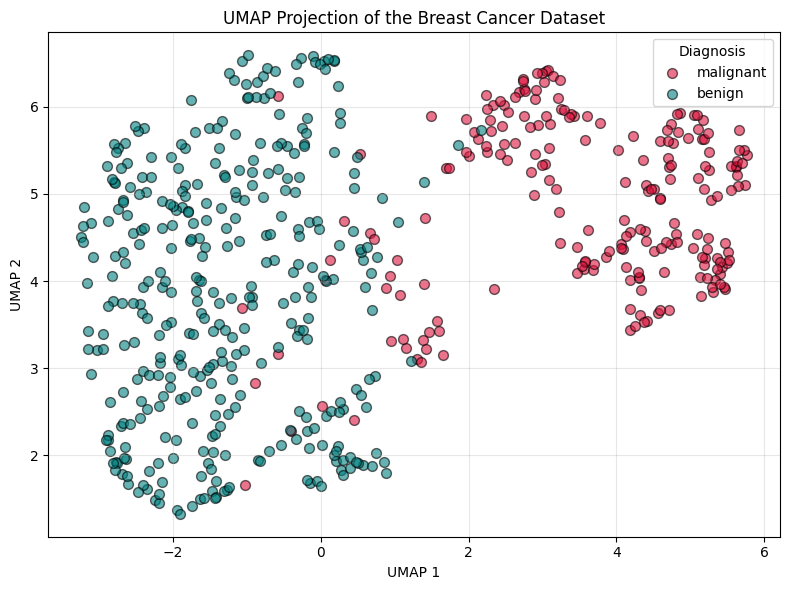

In [21]:
# Fit UMAP
umap_reducer = UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

colors = ['crimson', 'teal']

# Plot
plt.figure(figsize=(8, 6))
for label, name, color in zip([0, 1], outcome_names, colors):
    plt.scatter(X_umap[y == label, 0],
                X_umap[y == label, 1],
                alpha=0.6,
                label=name,
                c=color,
                edgecolor='k',
                s=50)

plt.title("UMAP Projection of the Breast Cancer Dataset")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Diagnosis')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## K-Means / K-Medoids

Let's start with K-Means and K-Medoids!

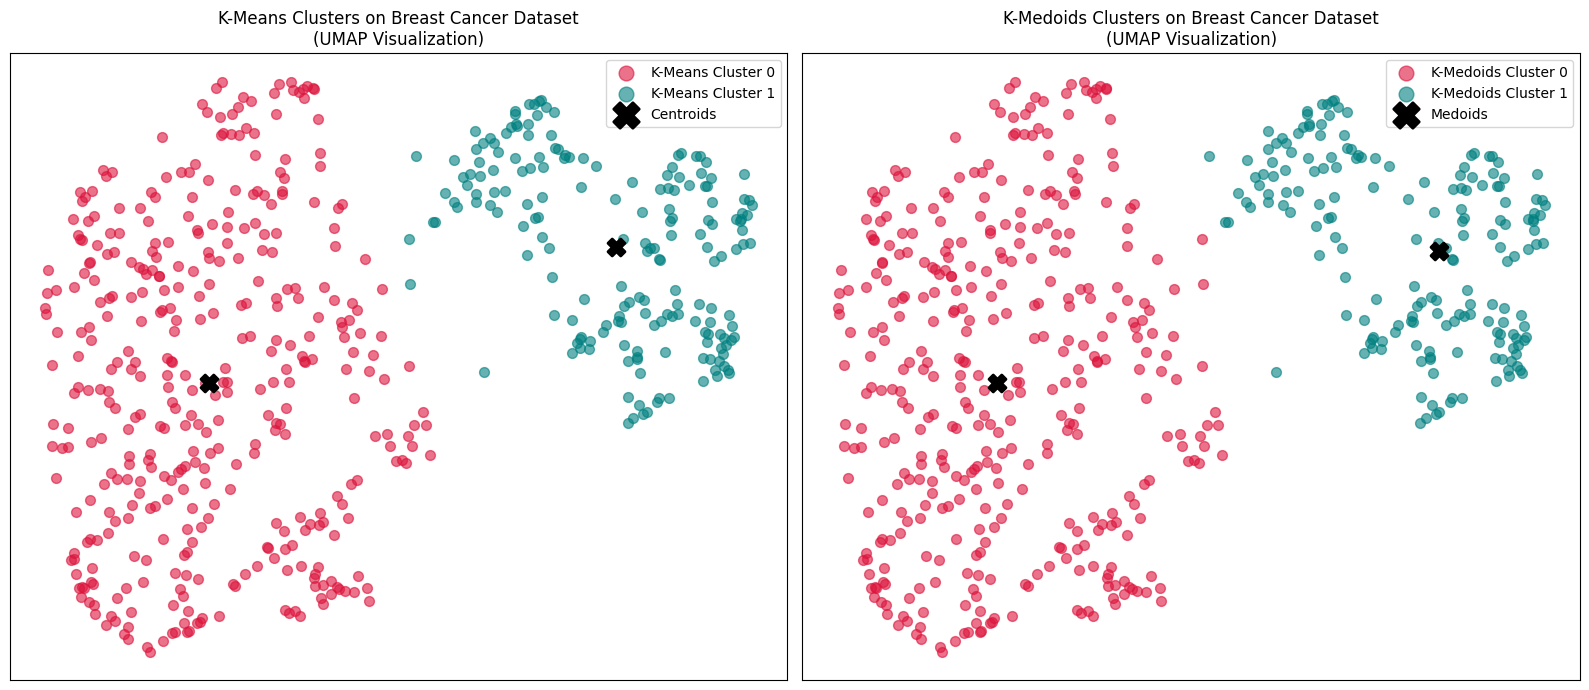

In [14]:
# K-Means clustering on Umap reduced data
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_umap)

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- K-Means subplot ---
for i in range(2):
    idx = kmeans.labels_ == i
    axs[0].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.6, 
                   color=colors[i], label=f"K-Means Cluster {i}")

# Plot cluster centroids
centroids_umap = kmeans.cluster_centers_ #umap.transform(kmeans.cluster_centers_) # TODO remove this once decided if we continue with UMAP or not
axs[0].scatter(centroids_umap[:, 0], centroids_umap[:, 1], 
               c='black', marker='X', s=150, linewidth=2, label='Centroids')

axs[0].set_title('K-Means Clusters on Breast Cancer Dataset\n(UMAP Visualization)', fontsize=12)
axs[0].legend(markerscale=1.5)

# K-Medoids clustering
kmed = kmedoids.KMedoids(n_clusters=2, random_state=42)
euclidean_dist = pairwise_distances(X_umap, metric='euclidean')

kmed.fit(euclidean_dist)

# --- K-Medoids subplot ---
for i in range(2):
    idx = kmed.labels_ == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.6, 
                   color=colors[i], label=f"K-Medoids Cluster {i}")

# Plot medoids
medoids_umap = X_umap[kmed.medoid_indices_]
axs[1].scatter(medoids_umap[:, 0], medoids_umap[:, 1], 
               c='black', marker='X', s=150, linewidth=2, label='Medoids')

axs[1].set_title('K-Medoids Clusters on Breast Cancer Dataset\n(UMAP Visualization)', fontsize=12)
axs[1].legend(markerscale=1.5)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### K-Means vs K-Medoids on Breast Cancer Dataset:

**Visual Results:**
- **Nearly identical clustering**: Both methods produce very similar cluster assignments with clear separation
- **Two distinct patient groups**: Red cluster (benign-like) and blue cluster (malignant-like) with minimal overlap
- **Robust performance**: Both algorithms successfully identify meaningful patterns in breast cancer diagnostic features

**Medical Dataset Application:**
- **K-Means**: Fast computation, good for large patient databases, but sensitive to extreme diagnostic values
- **K-Medoids**: More robust to outliers (unusual patient cases), uses actual patient profiles as cluster centers
- **Clinical Advantage**: K-medoids provides interpretable "representative patients" for each cluster, making it easier for clinicians to understand typical cases in each group
- **Recommendation**: K-medoids preferred for medical datasets due to outlier robustness and clinical interpretability

## Hierarchical Clustering

Next let's visualize the Dendogram using Ward's method and the resulting cluster if we set the cutoff at 2 clusters.

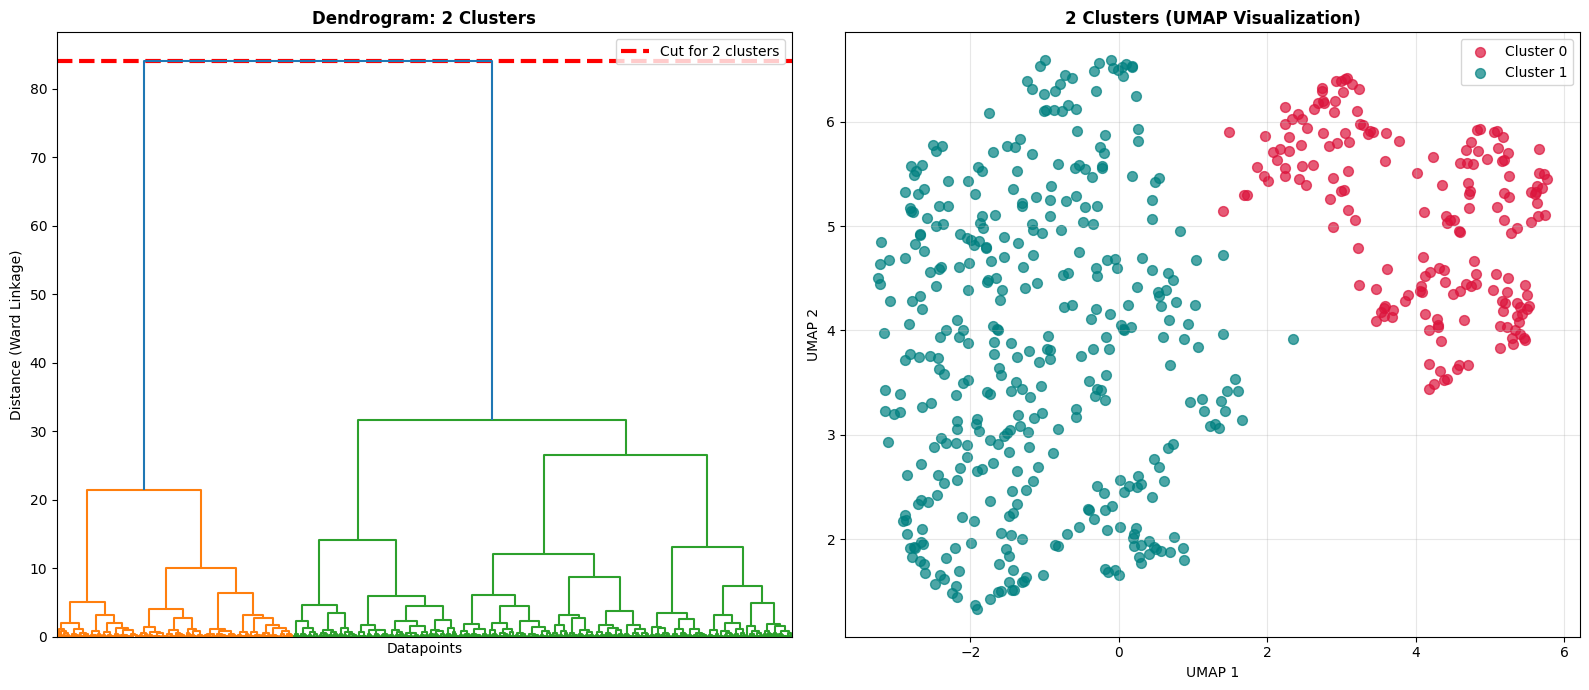

In [22]:
# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_umap, method='ward')

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Top row: Three dendrograms with different cluster cuts
n_clusters_list = [2]
colors_cuts = ['red']

ax = axes[0]

# Find the distance threshold for n_clusters
threshold = linkage_matrix[-1, 2]
ax.axhline(y=threshold, color=colors_cuts[0], linestyle='--', linewidth=3,
            label=f'Cut for 2 clusters')
        
# Create dendrogram
dend = dendrogram(linkage_matrix, 
                  #truncate_mode='level', 
                  p=10,
                  leaf_rotation=90,
                  leaf_font_size=8,
                  show_leaf_counts=False,
                  color_threshold=threshold,
                  #link_color_func=lambda k: colors[k] if k < len(colors) else 'black',
                  ax=ax)

ax.set_title(f'Dendrogram: 2 Clusters', fontsize=12, fontweight='bold')
ax.set_xlabel('Datapoints', fontsize=10)
ax.set_ylabel('Distance (Ward Linkage)', fontsize=10)
ax.legend(loc='upper right')

# Remove x-axis tick labels
ax.set_xticks([])

ax = axes[1]
    
# Get cluster labels for n_clusters
cluster_labels = fcluster(linkage_matrix, 2, criterion='maxclust') - 1

# Plot points colored by cluster
for cluster_id in range(2):
    mask = cluster_labels == cluster_id
    ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
              c=colors[cluster_id], s=50, alpha=0.7,
              label=f'Cluster {cluster_id}')

ax.set_title(f'2 Clusters (UMAP Visualization)', fontsize=12, fontweight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Observations - Hierarchical Clustering on Breast Cancer Dataset:

- **Clear binary separation**: Dendrogram shows distinct cut at ~85 distance, creating two well-defined clusters
- **Medically meaningful**: Two clusters likely correspond to benign vs malignant breast cancer cases
- **Excellent separation**: UMAP visualization shows minimal overlap between red and teal clusters
- **Balanced clustering**: Both clusters contain substantial patient populations for meaningful analysis
- **Clinical relevance**: Hierarchical approach naturally identifies the primary diagnostic distinction in breast cancer data

## DBSCAN

Finally let's use DBSCAN again with different values for epsilon and MinPts!

TODO: Maybe add the K-Distance graph to figure out good values?

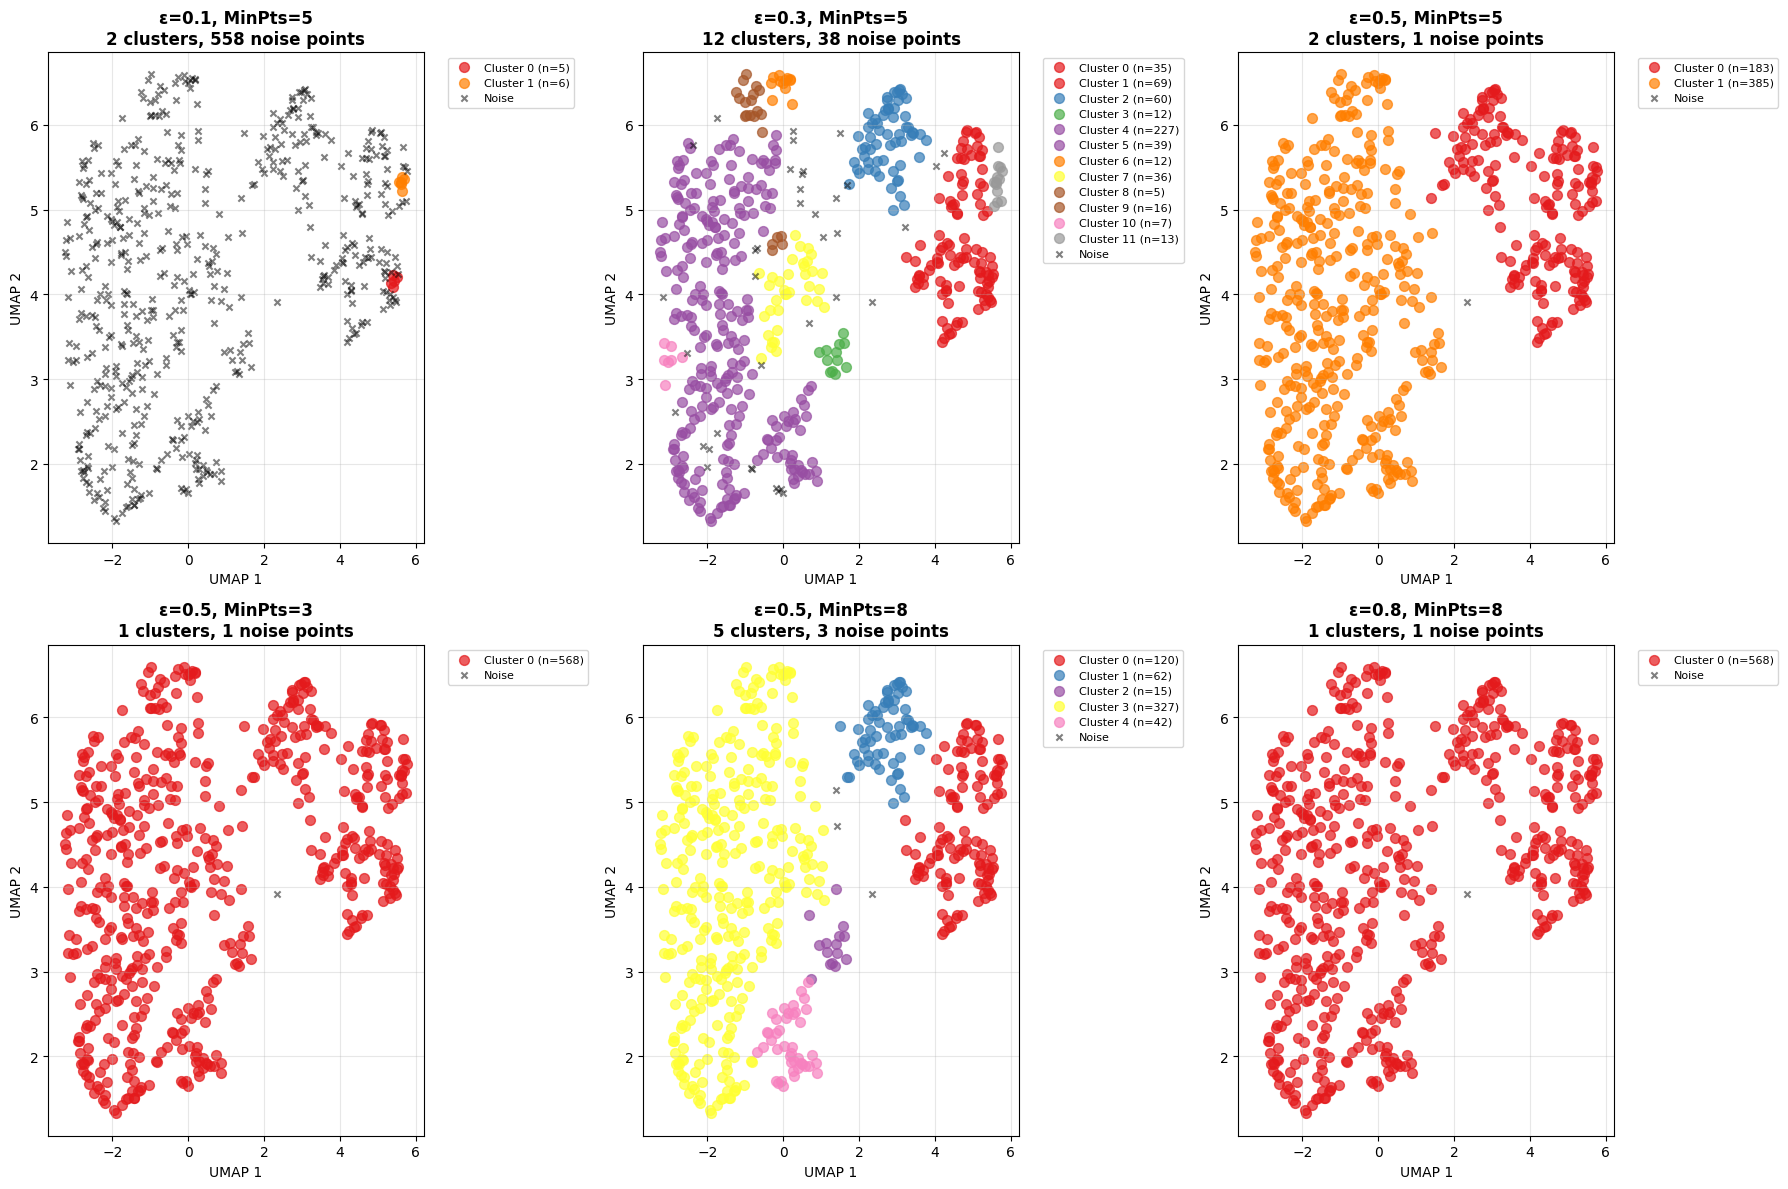

In [27]:
# Parameter Sensitivity Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Different epsilon and MinPts combinations
param_combinations = [
    (0.1, 5, "ε=0.1, MinPts=5"),
    (0.3, 5, "ε=0.3, MinPts=5"), 
    (0.5, 5, "ε=0.5, MinPts=5"),
    (0.5, 3, "ε=0.5, MinPts=3"),
    (0.5, 8, "ε=0.5, MinPts=8"),
    (0.8, 8, "ε=0.8, MinPts=8")
]

for i, (eps, min_pts, title) in enumerate(param_combinations):
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    cluster_labels = dbscan.fit_predict(X_umap)
    
    # Count clusters and noise
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    # Plot results
    ax = axes[i]
    
    # Plot clusters
    unique_labels = set(cluster_labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points in black
            mask = cluster_labels == label
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c='black', s=20, alpha=0.5, marker='x', label='Noise')
        else:
            mask = cluster_labels == label
            cluster_size = np.sum(mask)
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c=[color], s=50, alpha=0.7, 
                      label=f'Cluster {label} (n={cluster_size})')
    
    ax.set_title(f'{title}\n{n_clusters} clusters, {n_noise} noise points', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Observations - DBSCAN on Breast Cancer Dataset:

**Parameter Sensitivity:**
- **ε=0.3-**: Too restrictive - creates too many clusters with 558 noise points (most patients unclassified)
- **ε=0.5**: Optimal balance - meaningful clusters with only a few noise points
- **ε=0.8+**: Too permissive - merges distinct patient groups into fewer clusters
- **MinPts**: has a large impact aswell, when we choose it too small (for instance 3), we merge clusters faster than we would like.

**Clinical Advantages:**
- **Noise detection**: Identifies outlier patients (gray X's) who don't fit typical patterns
- **Automatic cluster count**: No need to specify number of patient subgroups beforehand
- **Robust clustering**: Handles varying cluster densities in medical data
- **Clinical insight**: Noise points may represent rare cases or measurement errors requiring special attention

**Best Practice**: ε=0.5, MinPts=5 provides optimal patient stratification with minimal noise

## Overview

**K-Means/K-Medoids:**
- **Best for**: Patient stratification when you know the number of groups (e.g., risk categories)
- **Advantage**: Fast, scalable for large patient databases
- **Use case**: Creating risk groups, treatment cohorts, or diagnostic categories

**Hierarchical Clustering:**
- **Best for**: Understanding patient relationships and creating clinical decision trees
- **Advantage**: Visual dendrogram shows how patient groups relate to each other
- **Use case**: Identifying disease subtypes or treatment response patterns

**DBSCAN:**
- **Best for**: Discovering unknown patient subgroups and identifying outliers
- **Advantage**: Finds rare patient types and unusual cases automatically
- **Use case**: Detecting rare diseases, unusual treatment responses, or data quality issues

**Clinical Recommendation**: Start with hierarchical clustering for exploration, use K-means for known categories, apply DBSCAN for outlier detection.

---